In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50#Constituents')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-03-02'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close         close          high  \
date       ticker                                                    
2016-03-04 ADANIENT.NS       33.381958     34.437756     35.227863   
           ADANIPORTS.NS    215.255295    225.149994    228.850006   
           APOLLOHOSP.NS   1369.547241   1410.099976   1437.000000   
           ASIANPAINT.NS    820.093018    865.799988    890.099976   
           AXISBANK.NS      406.644196    416.049988    418.149994   
...                                ...           ...           ...   
2024-03-01 TECHM.NS        1271.800049   1271.800049   1287.000000   
           TITAN.NS        3765.899902   3765.899902   3774.000000   
           ULTRACEMCO.NS  10135.500000  10135.500000  10183.849609   
           UPL.NS           474.549988    474.549988    477.899994   
           WIPRO.NS         519.099976    519.099976    525.200012   

                                  low         open     volume  
date       ticker                                              
2016-03-04 ADANIENT.NS      34.056328    34.328777  9013442.0  
           ADANIPORTS.NS   222.199997   228.850006  4768604.0  
           APOLLOHOSP.NS  1380.000000  1435.000000   345879.0  
           ASIANPAINT.NS   858.400024   886.599976  1039977.0  
           AXISBANK.NS     409.250000   418.149994  8992492.0  
...                               ...          ...        ...  
2024-03-01 TECHM.NS       1268.000000  1287.000000  1560034.0  
           TITAN.NS       3626.000000  3630.000000  1533727.0  
           ULTRACEMCO.NS  9892.400391  9900.000000   352952.0  
           UPL.NS          471.149994   474.000000  2877161.0  
           WIPRO.NS        517.549988   522.400024  4710315.0  

[97800 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close         close          high  \
date       ticker                                                    
2016-03-04 ADANIENT.NS       33.381958     34.437756     35.227863   
           ADANIPORTS.NS    215.255295    225.149994    228.850006   
           APOLLOHOSP.NS   1369.547241   1410.099976   1437.000000   
           ASIANPAINT.NS    820.093018    865.799988    890.099976   
           AXISBANK.NS      406.644196    416.049988    418.149994   
...                                ...           ...           ...   
2024-03-01 TECHM.NS        1271.800049   1271.800049   1287.000000   
           TITAN.NS        3765.899902   3765.899902   3774.000000   
           ULTRACEMCO.NS  10135.500000  10135.500000  10183.849609   
           UPL.NS           474.549988    474.549988    477.899994   
           WIPRO.NS         519.099976    519.099976    525.200012   

                                  low         open     volume  \
date       ticker                                               
2016-03-04 ADANIENT.NS      34.056328    34.328777  9013442.0   
           ADANIPORTS.NS   222.199997   228.850006  4768604.0   
           APOLLOHOSP.NS  1380.000000  1435.000000   345879.0   
           ASIANPAINT.NS   858.400024   886.599976  1039977.0   
           AXISBANK.NS     409.250000   418.149994  8992492.0   
...                               ...          ...        ...   
2024-03-01 TECHM.NS       1268.000000  1287.000000  1560034.0   
           TITAN.NS       3626.000000  3630.000000  1533727.0   
           ULTRACEMCO.NS  9892.400391  9900.000000   352952.0   
           UPL.NS          471.149994   474.000000  2877161.0   
           WIPRO.NS        517.549988   522.400024  4710315.0   

                          garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2016-03-04 ADANIENT.NS            0.000270        NaN       NaN       NaN   
           ADANIPORTS.NS         -0.001014        NaN       NaN       NaN   
           APOLLOHOSP.NS         -0.000023        NaN       NaN       NaN   
           ASIANPAINT.NS         -0.001691        NaN       NaN       NaN   
           AXISBANK.NS           -0.000069        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-03-01 TECHM.NS               0.000056  45.308404  7.147596  7.177232   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   
           ULTRACEMCO.NS          0.000208  55.710372  9.184813  9.205351   
           UPL.NS                 0.000101  35.886913  6.129151  6.177267   
           WIPRO.NS               0.000092  58.720675  6.179884  6.247646   

                           bb_high       atr      macd  dollar_volume  
date       ticker                                                      
2016-03-04 ADANIENT.NS         NaN       NaN       NaN     300.886342  
           ADANIPORTS.NS       NaN       NaN       NaN    1026.467260  
           APOLLOHOSP.NS       NaN       NaN       NaN     473.697630  
           ASIANPAINT.NS       NaN       NaN       NaN     852.877876  
           AXISBANK.NS         NaN       NaN       NaN    3656.744675  
...                            ...       ...       ...            ...  
2024-03-01 TECHM.NS       7.206867  0.606050 -0.531336    1984.051317  
           TITAN.NS       8.226478  2.399310 -0.268556    5775.862360  
           ULTRACEMCO.NS  9.225890  1.925823 -0.189835    3577.344996  
           UPL.NS         6.225382 -0.951797 -1.155123    1365.356717  
           WIPRO.NS       6.315408  1.446324  1.511336    2445.124402  

[97800 rows x 14 columns]

# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [3]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume     adj close  garman_klass_vol  \
date       ticker                                                         
2016-04-30 ADANIENT.NS       358.963345     46.289902          0.002073   
           ADANIPORTS.NS     814.750765    228.763748          0.000109   
           APOLLOHOSP.NS     292.711052   1279.894409         -0.000040   
           ASIANPAINT.NS     554.454657    820.519287         -0.001348   
           AXISBANK.NS      4460.035157    461.720276          0.000301   
...                                 ...           ...               ...   
2024-03-31 TECHM.NS         1984.051317   1271.800049          0.000056   
           TITAN.NS         5775.862360   3765.899902          0.000278   
           ULTRACEMCO.NS    3577.344996  10135.500000          0.000208   
           UPL.NS           1365.356717    474.549988          0.000101   
           WIPRO.NS         2445.124402    519.099976          0.000092   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-04-30 ADANIENT.NS    70.824860  3.675950  3.777785  3.879619 -0.742599   
           ADANIPORTS.NS  55.082984  5.345807  5.414908  5.484009 -0.958142   
           APOLLOHOSP.NS  36.802700  7.149177  7.179937  7.210697 -0.914517   
           ASIANPAINT.NS  48.451305  6.693650  6.718269  6.742887 -1.308157   
           AXISBANK.NS    63.814003  6.006918  6.087518  6.168117 -0.843494   
...                             ...       ...       ...       ...       ...   
2024-03-31 TECHM.NS       45.308404  7.147596  7.177232  7.206867  0.606050   
           TITAN.NS       57.901359  8.164501  8.195490  8.226478  2.399310   
           ULTRACEMCO.NS  55.710372  9.184813  9.205351  9.225890  1.925823   
           UPL.NS         35.886913  6.129151  6.177267  6.225382 -0.951797   
           WIPRO.NS       58.720675  6.179884  6.247646  6.315408  1.446324   

                              macd  
date       ticker                   
2016-04-30 ADANIENT.NS   -0.122908  
           ADANIPORTS.NS -0.208455  
           APOLLOHOSP.NS -0.507706  
           ASIANPAINT.NS -0.198966  
           AXISBANK.NS    0.664244  
...                            ...  
2024-03-31 TECHM.NS      -0.531336  
           TITAN.NS      -0.268556  
           ULTRACEMCO.NS -0.189835  
           UPL.NS        -1.155123  
           WIPRO.NS       1.511336  

[4757 rows x 9 columns]

In [4]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-11-30  5392.606281    4469.741522    2343.440053    3458.263420   
2023-12-31  5623.716075    4627.327943    2376.815454    3480.072211   
2024-01-31  5795.943235    4759.277964    2398.398574    3506.240357   
2024-02-29  5880.684152    4804.832738    2430.085505    3556.614357   
2024-03-31  5933.570132    4856.511729    2592.190292    3577.580810   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
2016-06-30          NaN            NaN            NaN            NaN   
2016-07-31          NaN            NaN            NaN            NaN   
2016-08-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-11-30  9182.269949    1706.573620    3892.992000   10295.342628   
2023-12-31  9268.108798    1741.324673    3906.341315   10358.063934   
2024-01-31  9326.845935    1806.238963    3924.485950   10468.416994   
2024-02-29  9375.474056    1842.388925    3935.039839   10551.352826   
2024-03-31  9343.225146    1867.808447    3930.400632   10588.235058   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SUNPHARMA.NS  TATACONSUM.NS  \
date                                    ...                                
2016-04-30            NaN          NaN  ...           NaN            NaN   
2016-05-31            NaN          NaN  ...           NaN            NaN   
2016-06-30            NaN          NaN  ...           NaN            NaN   
2016-07-31            NaN          NaN  ...           NaN            NaN   
2016-08-31            NaN          NaN  ...           NaN            NaN   
...                   ...          ...  ...           ...            ...   
2023-11-30    6489.286562  2149.076674  ...   3429.639163    1451.026715   
2023-12-31    6548.893007  2215.049415  ...   3333.142409    1470.698133   
2024-01-31    6623.111925  2273.117452  ...   3283.208427    1499.600819   
2024-02-29    6702.487538  2409.858028  ...   3297.854880    1523.669521   
2024-03-31    6762.150076  2466.724922  ...   3355.131322    1553.123290   

ticker      TATAMOTORS.NS  TATASTEEL.NS       TCS.NS     TECHM.NS  \
date                                                                
2016-04-30            NaN           NaN          NaN          NaN   
2016-05-31            NaN           NaN          NaN          NaN   
2016-06-30            NaN           NaN          NaN          NaN   
2016-07-31            NaN           NaN          NaN          NaN   
2016-08-31            NaN           NaN          NaN          NaN   
...                   ...           ...          ...          ...   
2023-11-30    9218.938131   7293.391021  7337.597578  2853.486551   
2023-12-31    9308.651271   7326.598728  7406.632493  2879.056757   
2024-01-31    9420.836257   7365.080228  7465.000193  2918.923277   
2024-02-29    9525.523374   7387.868615  7511.203202  2907.022829   
2024-03-31    9643.022514   7650.733144  7566.629656  2904.500815   

ticker         TITAN.NS  ULTRACEMCO.NS       UPL.NS     WIPRO.NS  
date                                                              
2016-04-30          NaN            NaN          NaN          NaN  
2016-05-31          NaN            NaN

In [5]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<30].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [6]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-04-30 ADANIPORTS.NS   228.763748          0.000109  55.082984  5.345807   
           AXISBANK.NS     461.720276          0.000301  63.814003  6.006918   
           BHARTIARTL.NS   314.735168         -0.000978  58.994191  5.649614   
           CIPLA.NS        516.641296          0.000067  56.196774  6.164615   
           COALINDIA.NS    151.817352         -0.153051  49.601994  4.970321   
...                               ...               ...        ...       ...   
2024-03-31 SUNPHARMA.NS   1559.250000          0.000166  70.282065  7.288569   
           TATAMOTORS.NS   977.400024          0.000159  73.035404  6.803003   
           TATASTEEL.NS    149.949997          0.000488  63.192494  4.928721   
           TCS.NS         4094.350098          0.000080  58.259872  8.291248   
           TITAN.NS       3765.899902          0.000278  57.901359  8.164501   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-04-30 ADANIPORTS.NS  5.414908  5.484009 -0.958142 -0.208455  
           AXISBANK.NS    6.087518  6.168117 -0.843494  0.664244  
           BHARTIARTL.NS  5.719719  5.789824 -0.722406  0.274120  
           CIPLA.NS       6.214468  6.264321 -1.049841 -0.130048  
           COALINDIA.NS   5.014072  5.057822  0.051349 -0.550393  
...                            ...       ...       ...       ...  
2024-03-31 SUNPHARMA.NS   7.334556  7.380543  3.019013  3.705632  
           TATAMOTORS.NS  6.839862  6.876722  2.655713  2.600015  
           TATASTEEL.NS   4.966901  5.005082  1.517843  0.933730  
           TCS.NS         8.315752  8.340256  1.547052  1.159520  
           TITAN.NS       8.195490  8.226478  2.399310 -0.268556  

[2784 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [7]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-04-30 AXISBANK.NS     502.786194          0.000178  53.415712  6.176689   
           HDFCBANK.NS     736.502319         -0.001161  73.350255  6.491661   
           HINDALCO.NS     190.727448          0.001572  58.105793  5.163354   
           ICICIBANK.NS    243.914551          0.000135  51.117142  5.465362   
           INDUSINDBK.NS  1387.292725         -0.000946  61.816260  7.202458   
...                               ...               ...        ...       ...   
2024-03-31 SUNPHARMA.NS   1559.250000          0.000166  70.282065  7.288569   
           TATAMOTORS.NS   977.400024          0.000159  73.035404  6.803003   
           TATASTEEL.NS    149.949997          0.000488  63.192494  4.928721   
           TCS.NS         4094.350098          0.000080  58.259872  8.291248   
           TITAN.NS       3765.899902          0.000278  57.901359  8.164501   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-04-30 AXISBANK.NS    6.210429  6.244168 -0.646374 -0.044190   0.038407   
           HDFCBANK.NS    6.553383  6.615105 -0.901571  0.761138   0.072060   
           HINDALCO.NS    5.216246  5.269138 -0.889097 -0.091142   0.022046   
           ICICIBANK.NS   5.501072  5.536782 -1.337058 -0.384067   0.005960   
           INDUSINDBK.NS  7.226385  7.250313 -0.911138  0.577870   0.013893   
...                            ...       ...       ...       ...        ...   
2024-03-31 SUNPHARMA.NS   7.334556  7.380543  3.019013  3.705632  -0.011851   
           TATAMOTORS.NS  6.839862  6.876722  2.655713  2.600015   0.028626   
           TATASTEEL.NS   4.966901  5.005082  1.517843  0.933730   0.064608   
           TCS.NS         8.315752  8.340256  1.547052  1.159520  -0.000183   
           TITAN.NS       8.195490  8.226478  2.399310 -0.268556   0.078869   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-04-30 AXISBANK.NS     0.002956   0.030296   0.007640  -0.007656   
           HDFCBANK.NS     0.054756   0.063236   0.034867   0.024278   
           HINDALCO.NS     0.039888   0.016231   0.048954   0.046256   
           ICICIBANK.NS    0.003883   0.011699   0.000991   0.006425   
           INDUSINDBK.NS   0.049205   0.048923   0.031472   0.023182   
...                             ...        ...        ...        ...   
2024-03-31 SUNPHARMA.NS    0.187731   0.143815   0.079382   0.070639   
           TATAMOTORS.NS   0.051383   0.078124   0.075885   0.056954   
           TATASTEEL.NS    0.050228   0.024127   0.025531   0.032954   
           TCS.NS          0.035836   0.027357   0.026326   0.025293   
           TITAN.NS        0.093608   0.066501   0.049754   0.053042   

                          return_12m  
date       ticker                     
2017-04-30 AXISBANK.NS      0.007126  
           HDFCBANK.NS      0.027015  
           HINDALCO.NS      0.063028  
           ICICIBANK.NS     0.015277  
           INDUSINDBK.NS    0.027412  
...                              ...  
2024-03-31 SUNPHARMA.NS     0.054749  
           TATAMOTORS.NS    0.073031  
           TATASTEEL.NS     0.033312  
           TCS.NS           0.022059  
           TITAN.NS         0.029899  

[2230 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [8]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-04-30 AXISBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.038407
           HDFCBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.072060
           HINDALCO.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.022046
           ICICIBANK.NS   0.0109  0.0048 -0.0213  0.0190 -0.0160   0.005960
           INDUSINDBK.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.013893
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TATAMOTORS.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.133662
           TATASTEEL.NS   0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.026146
           TCS.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.010606
           TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.189629
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[2173 rows x 6 columns]

In [9]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-04-30 AXISBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.038407
           HDFCBANK.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.072060
           HINDALCO.NS    0.0109  0.0048 -0.0213  0.0190 -0.0160   0.022046
           ICICIBANK.NS   0.0109  0.0048 -0.0213  0.0190 -0.0160   0.005960
           INDUSINDBK.NS  0.0109  0.0048 -0.0213  0.0190 -0.0160   0.013893
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TATAMOTORS.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.133662
           TATASTEEL.NS   0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.026146
           TCS.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.010606
           TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.189629
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[2144 rows x 6 columns]

In [10]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-04-30 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           HDFCBANK.NS         NaN       NaN       NaN       NaN       NaN
           HINDALCO.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INDUSINDBK.NS       NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-01-31 TATAMOTORS.NS  1.020325 -0.299088  0.524851 -0.090880 -0.791325
           TATASTEEL.NS   0.932080  0.765183 -0.665742 -0.151220  0.683278
           TCS.NS         0.518583  0.350367 -0.112678  0.154633  0.153418
           TECHM.NS       0.983420 -0.232087 -0.485430  0.062007  0.108398
           WIPRO.NS       1.136308  0.433045 -0.436588 -0.158494  0.279581

[2144 rows x 5 columns]

In [11]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2134 entries, (Timestamp('2017-04-30 00:00:00'), 'AXISBANK.NS') to (Timestamp('2024-03-31 00:00:00'), 'TITAN.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  2134 non-null   float64
 1   rsi               2134 non-null   float64
 2   bb_low            2134 non-null   float64
 3   bb_mid            2134 non-null   float64
 4   bb_high           2134 non-null   float64
 5   atr               2134 non-null   float64
 6   macd              2134 non-null   float64
 7   return_1m         2134 non-null   float64
 8   return_2m         2134 non-null   float64
 9   return_3m         2134 non-null   float64
 10  return_6m         2134 non-null   float64
 11  return_9m         2134 non-null   float64
 12  return_12m        2134 non-null   float64
 13  Mkt-RF            2134 non-null   float64
 14  SMB               2134 non-null   float64
 15 

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [12]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-04-30 AXISBANK.NS            0.000178  53.415712  6.176689  6.210429   
           HDFCBANK.NS           -0.001161  73.350255  6.491661  6.553383   
           HINDALCO.NS            0.001572  58.105793  5.163354  5.216246   
           ICICIBANK.NS           0.000135  51.117142  5.465362  5.501072   
           INDUSINDBK.NS         -0.000946  61.816260  7.202458  7.226385   
...                                    ...        ...       ...       ...   
2024-03-31 SUNPHARMA.NS           0.000166  70.282065  7.288569  7.334556   
           TATAMOTORS.NS          0.000159  73.035404  6.803003  6.839862   
           TATASTEEL.NS           0.000488  63.192494  4.928721  4.966901   
           TCS.NS                 0.000080  58.259872  8.291248  8.315752   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-04-30 AXISBANK.NS    6.244168 -0.646374 -0.044190   0.038407   0.002956   
           HDFCBANK.NS    6.615105 -0.901571  0.761138   0.072060   0.054756   
           HINDALCO.NS    5.269138 -0.889097 -0.091142   0.022046   0.039888   
           ICICIBANK.NS   5.536782 -1.337058 -0.384067   0.005960   0.003883   
           INDUSINDBK.NS  7.250313 -0.911138  0.577870   0.013893   0.049205   
...                            ...       ...       ...        ...        ...   
2024-03-31 SUNPHARMA.NS   7.380543  3.019013  3.705632  -0.011851   0.187731   
           TATAMOTORS.NS  6.876722  2.655713  2.600015   0.028626   0.051383   
           TATASTEEL.NS   5.005082  1.517843  0.933730   0.064608   0.050228   
           TCS.NS         8.340256  1.547052  1.159520  -0.000183   0.035836   
           TITAN.NS       8.226478  2.399310 -0.268556   0.078869   0.093608   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-04-30 AXISBANK.NS     0.030296   0.007640  -0.007656    0.007126   
           HDFCBANK.NS     0.063236   0.034867   0.024278    0.027015   
           HINDALCO.NS     0.016231   0.048954   0.046256    0.063028   
           ICICIBANK.NS    0.011699   0.000991   0.006425    0.015277   
           INDUSINDBK.NS   0.048923   0.031472   0.023182    0.027412   
...                             ...        ...        ...         ...   
2024-03-31 SUNPHARMA.NS    0.143815   0.079382   0.070639    0.054749   
           TATAMOTORS.NS   0.078124   0.075885   0.056954    0.073031   
           TATASTEEL.NS    0.024127   0.025531   0.032954    0.033312   
           TCS.NS          0.027357   0.026326   0.025293    0.022059   
           TITAN.NS        0.066501   0.049754   0.053042    0.029899   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-04-30 AXISBANK.NS    0.840137  0.206854  0.417771 -0.406144  0.041846   
           HDFCBANK.NS    0.462479  0.394104  0.200474  0.003533  0.154663   
           HINDALCO.NS    0.566076 -0.054949  1.514378 -1.341197 -1.412839   
           ICICIBANK.NS   0.709317 -0.596395  0.797990 -0.262552 -0.427731   
           INDUSINDBK.NS  1.027926  0.277441  0.420714 -1.010002 -0.042659   
...                            ...       ...       ...       ...       ...   
2024-03-31 SUNPHARMA.NS   1.283282 -0.587462 -0.646838 -0.115942  0.169477   
           TATAMOTORS.NS  1.272673  0.496451  0.941781  0.732124 -0.641652   
           TATASTEEL.NS   1.140259 -0.170260  0.664365 -0.139141 -0.609095   
           TCS.NS         0.438545  0.029909 -0.108676 -0.189796  0.129571   
           TITAN.NS       1.053662 -2.563038  1.986501 -0.099843 -2.923462   

                  

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
# the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    return

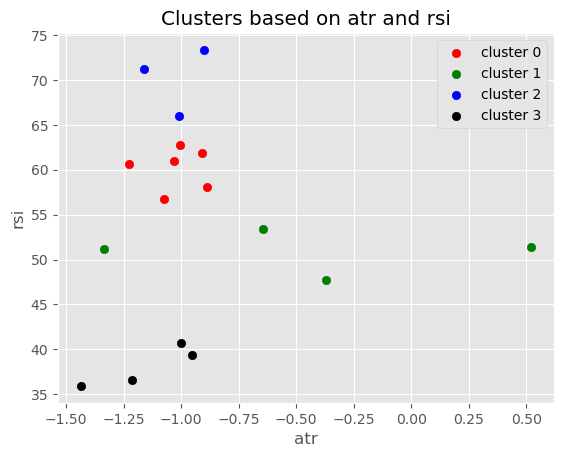

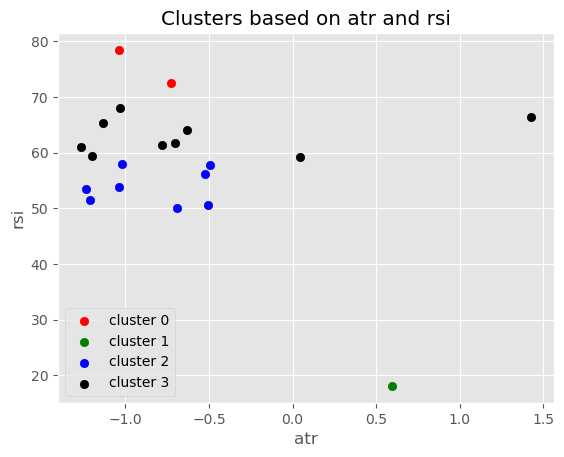

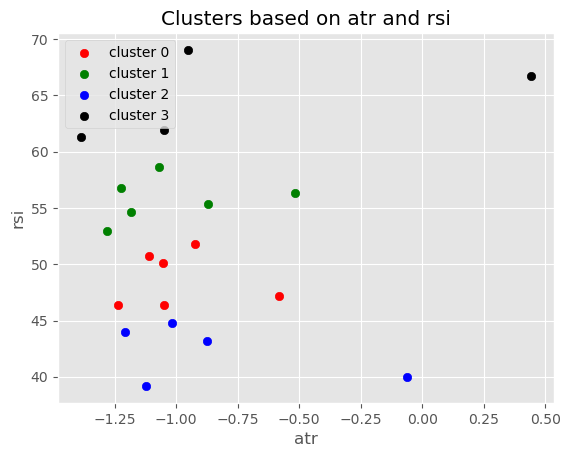

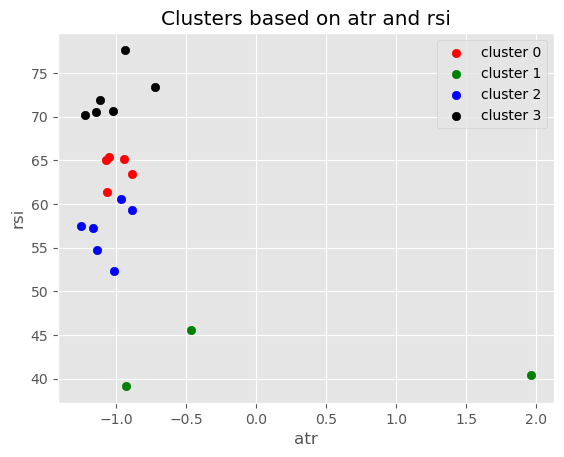

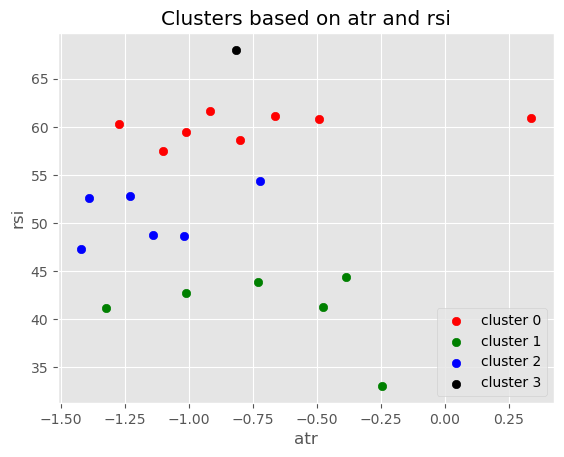

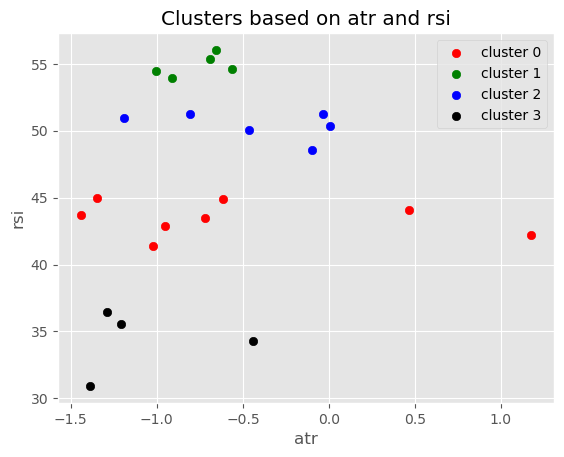

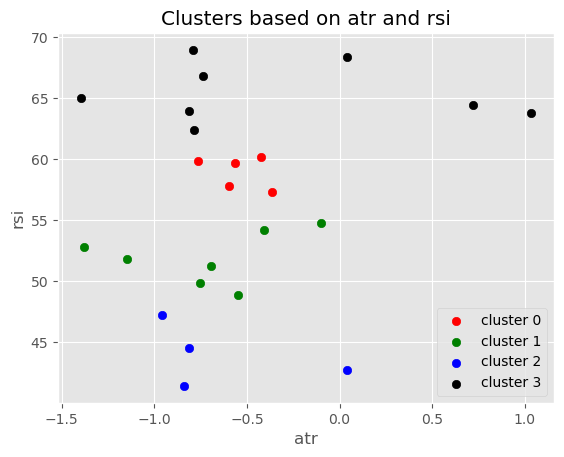

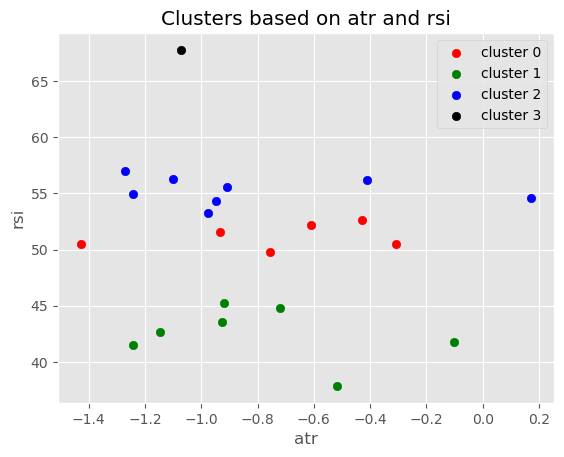

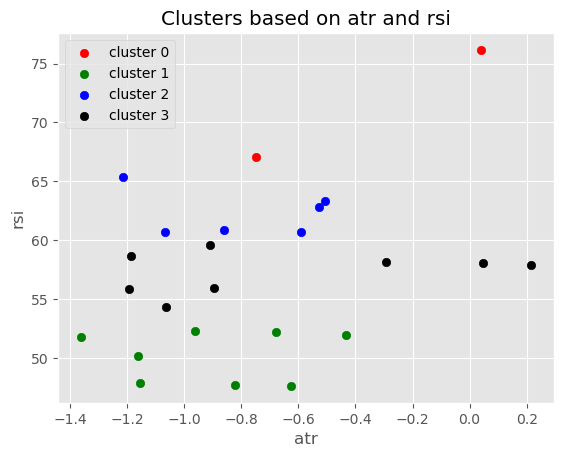

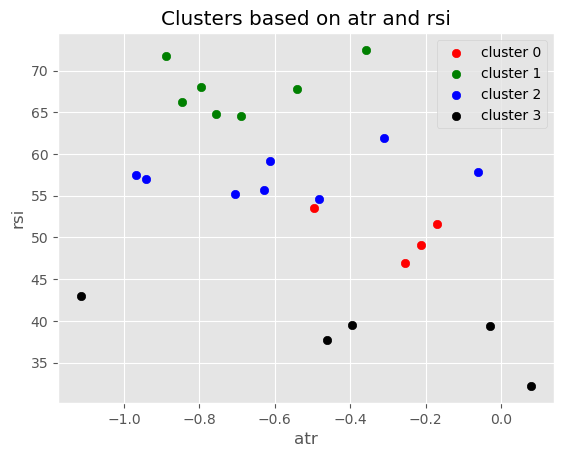

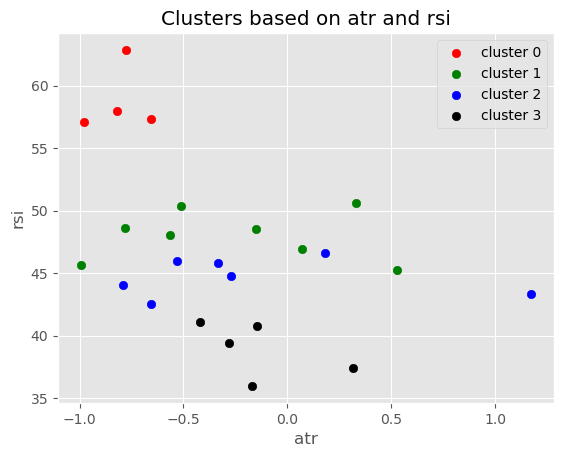

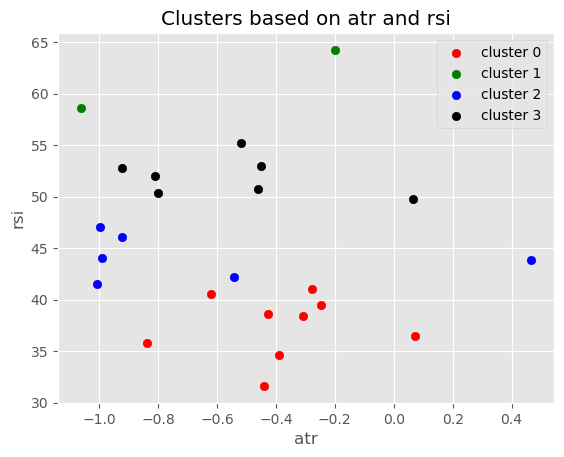

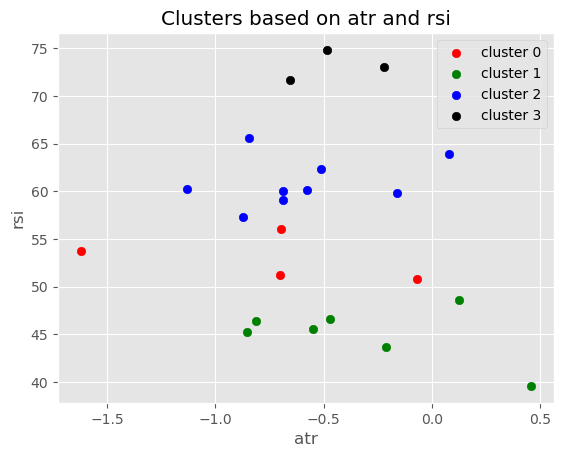

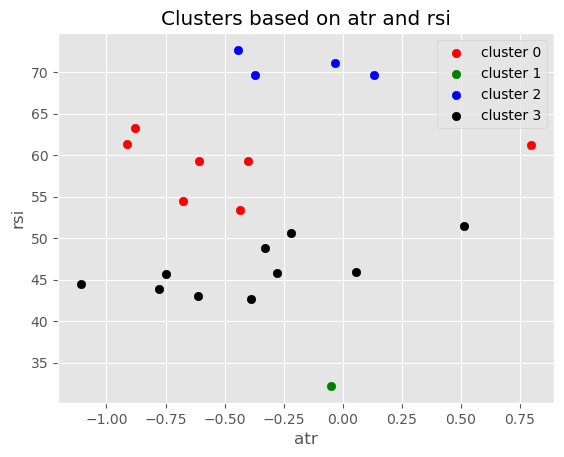

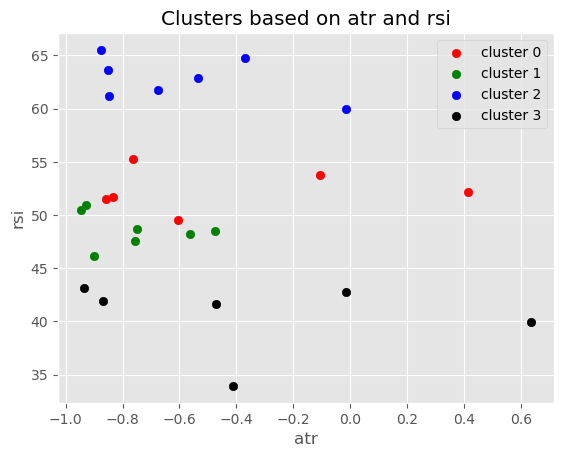

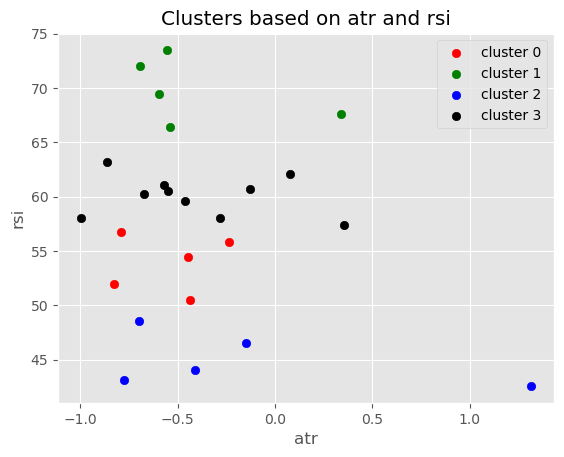

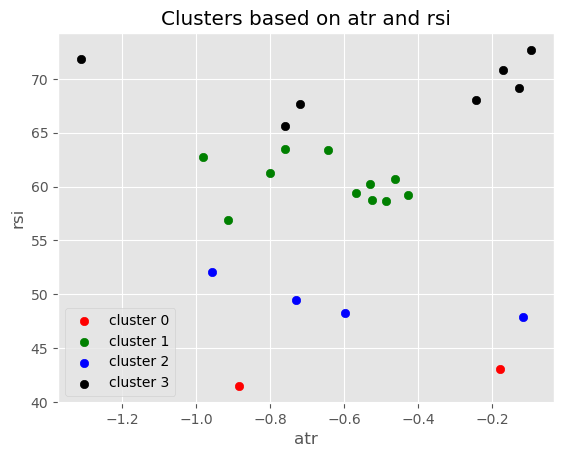

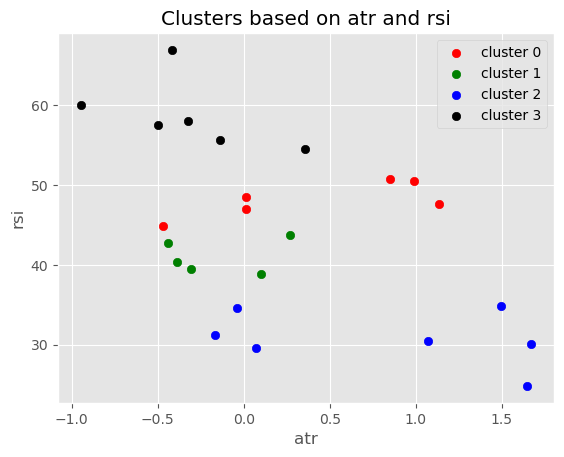

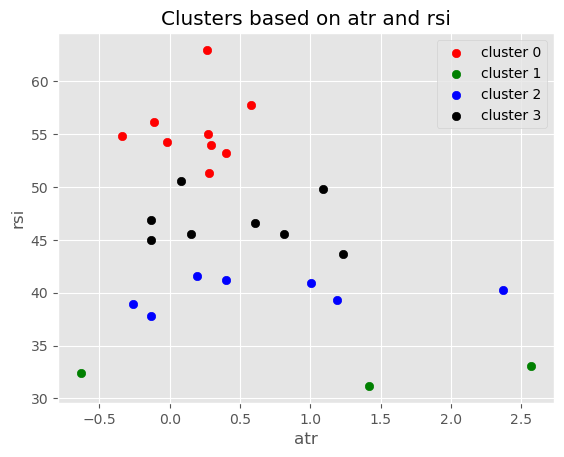

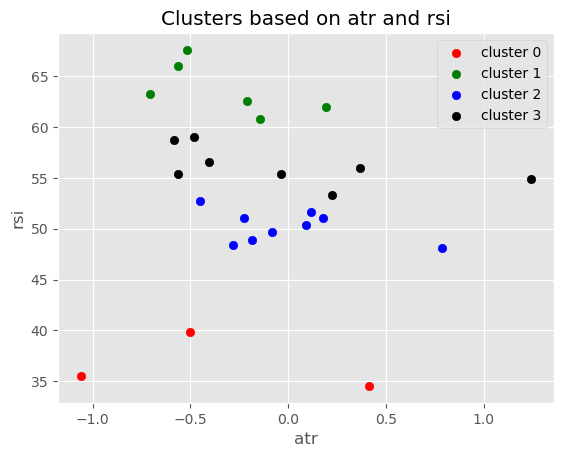

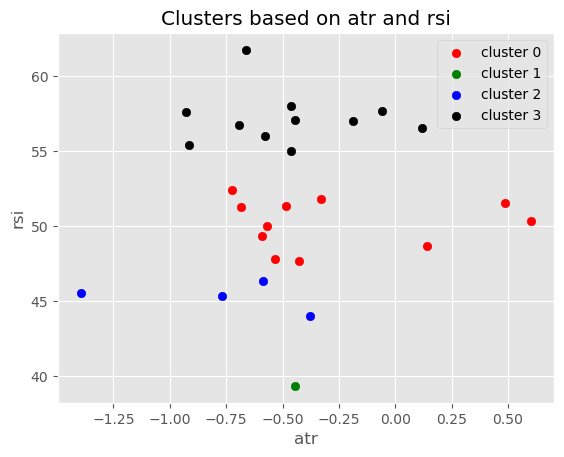

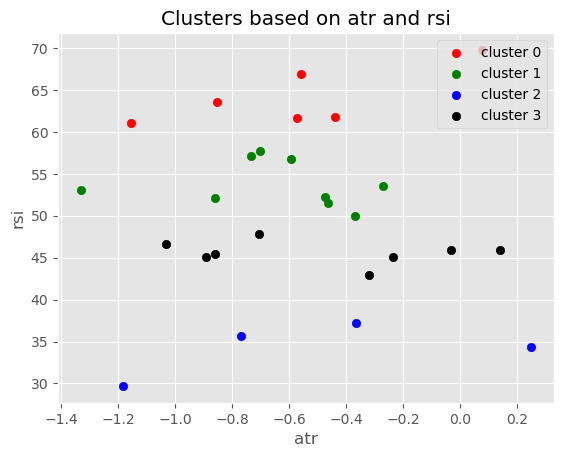

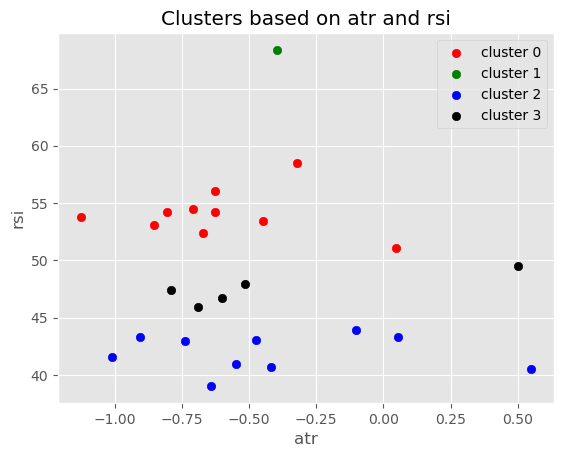

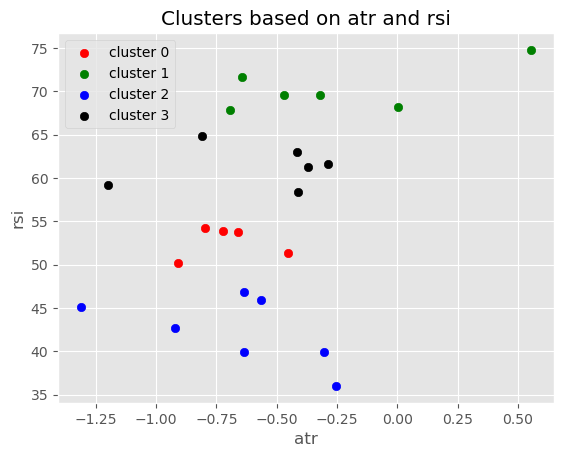

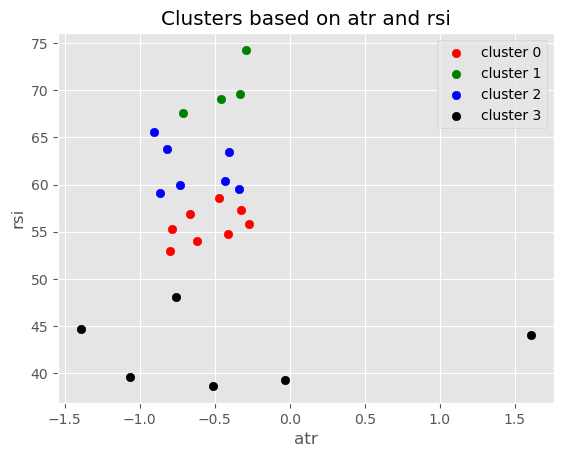

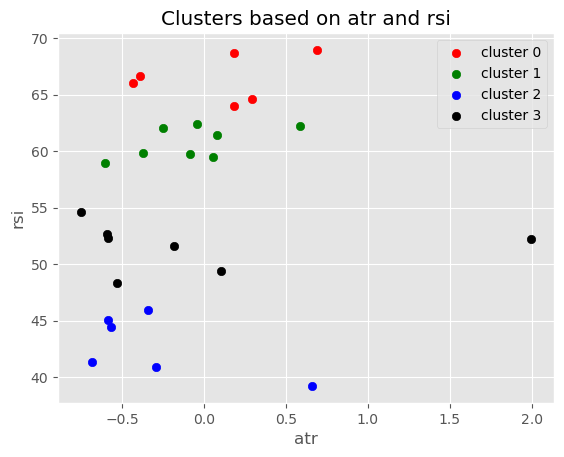

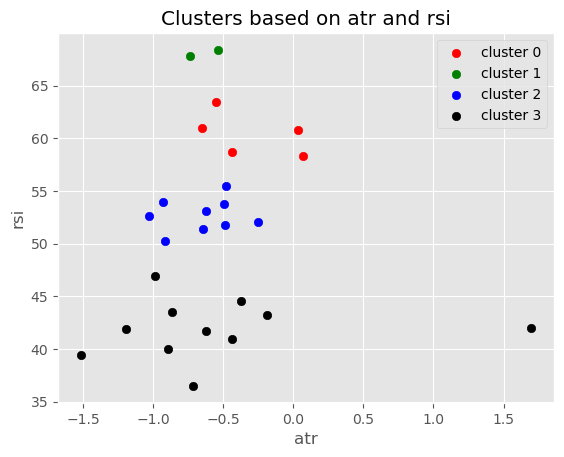

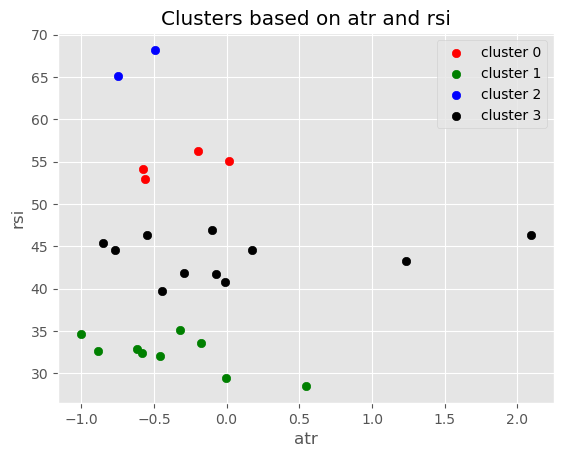

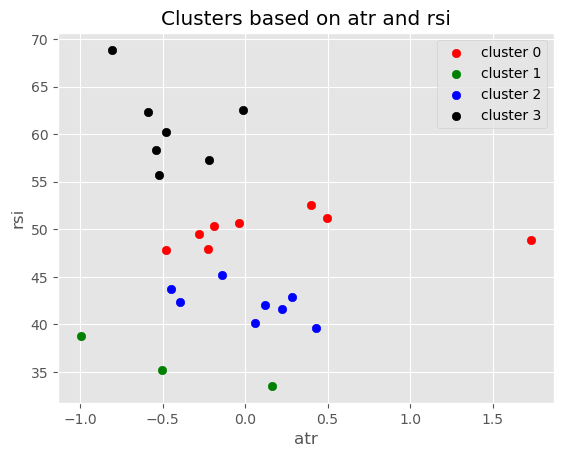

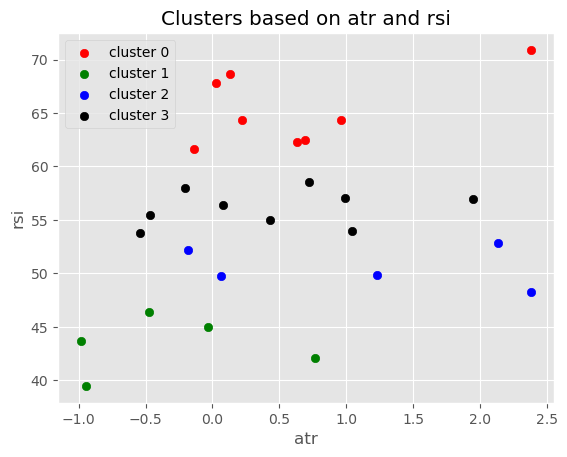

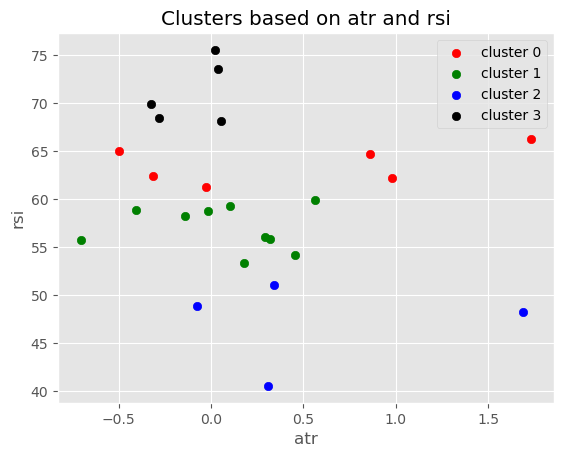

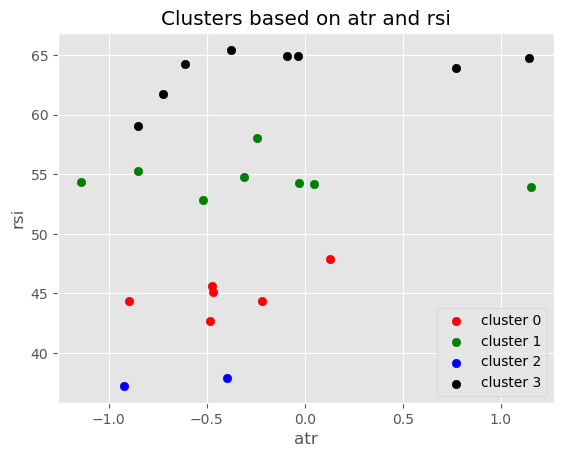

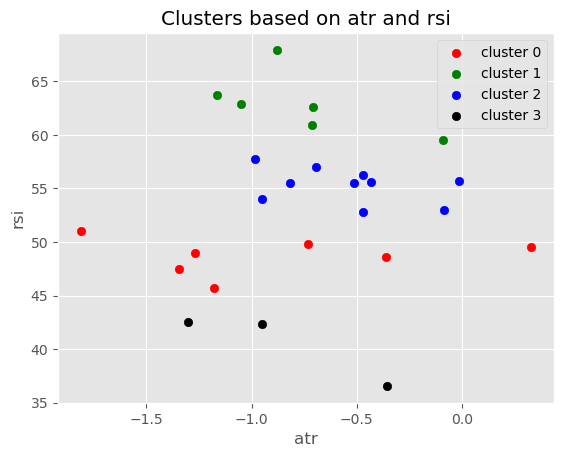

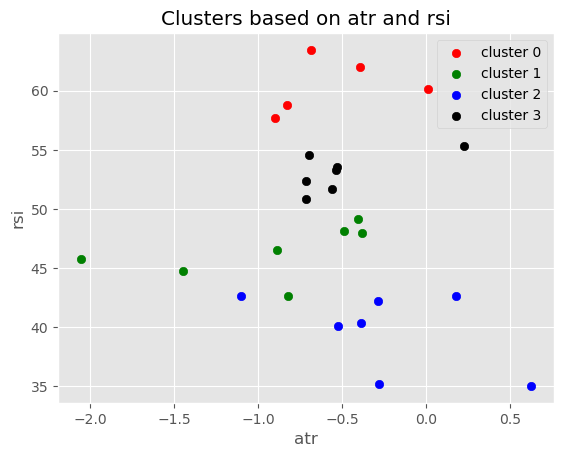

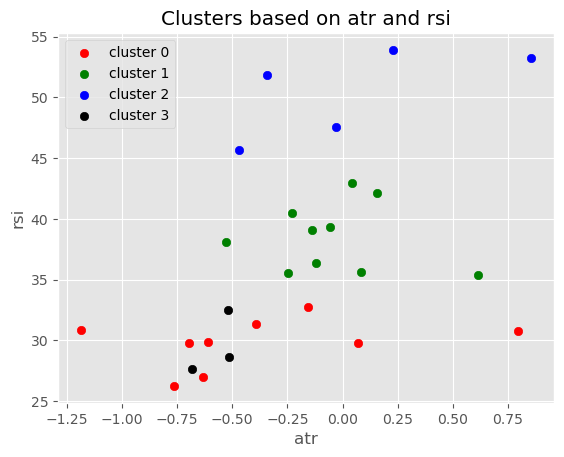

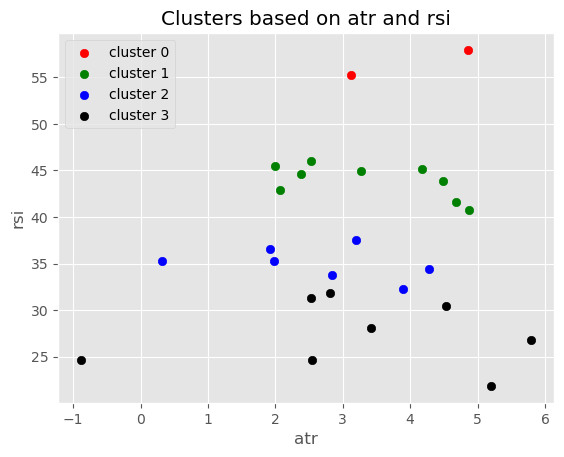

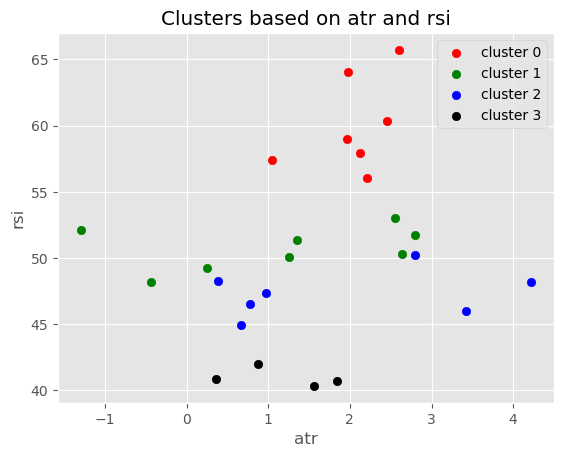

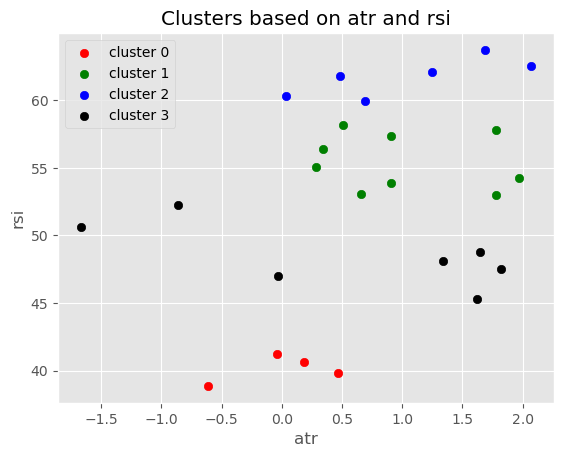

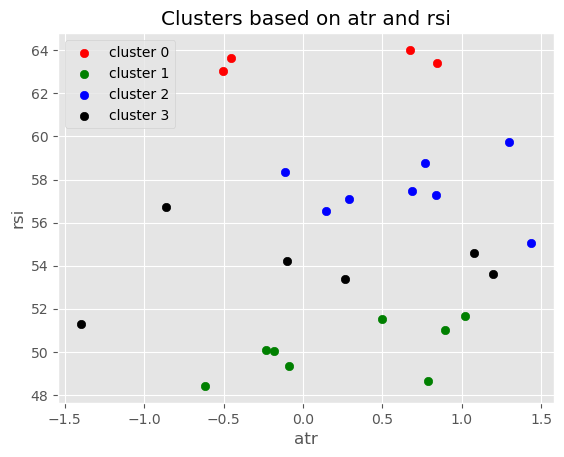

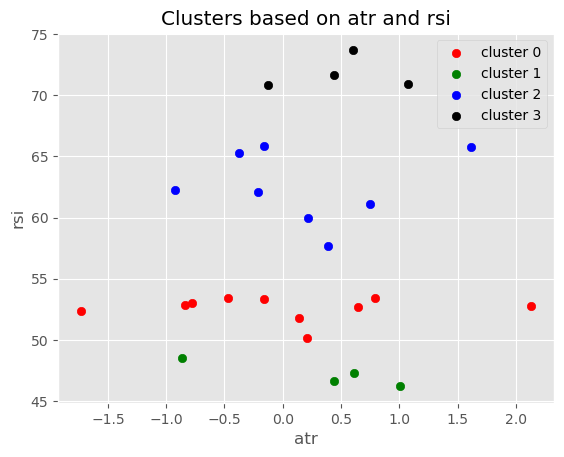

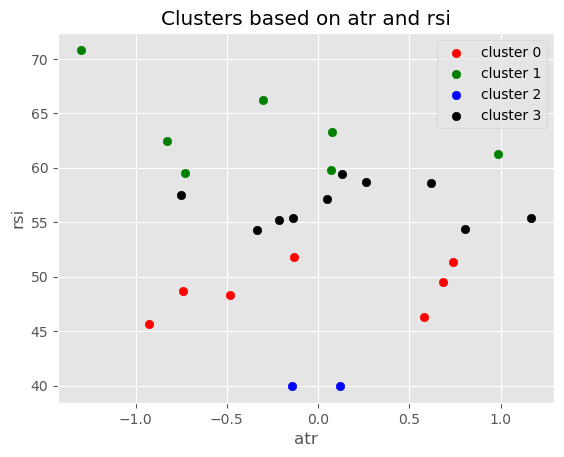

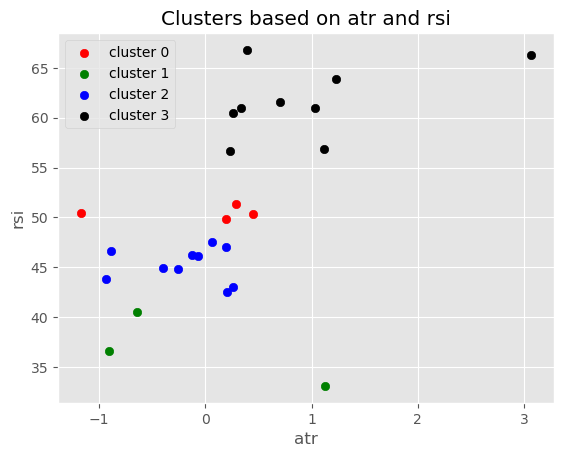

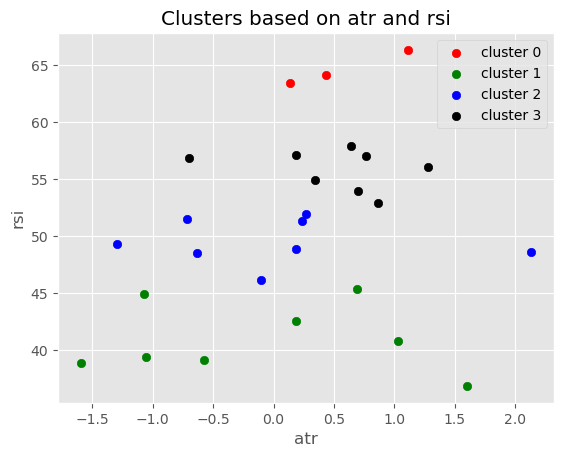

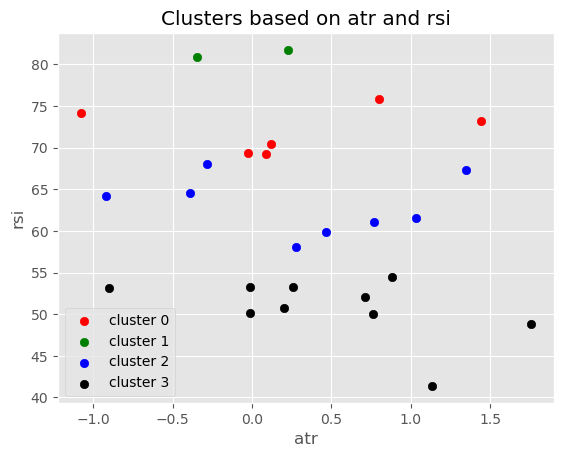

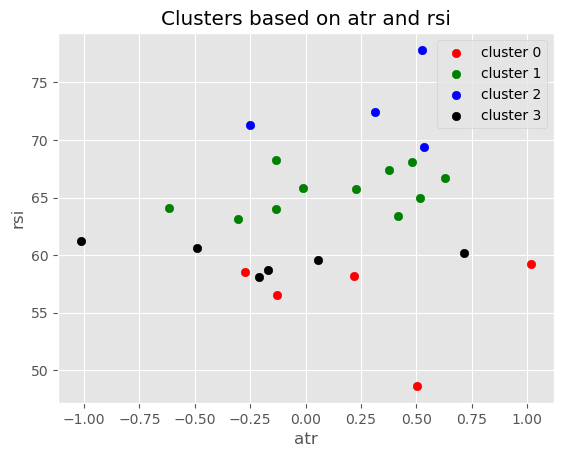

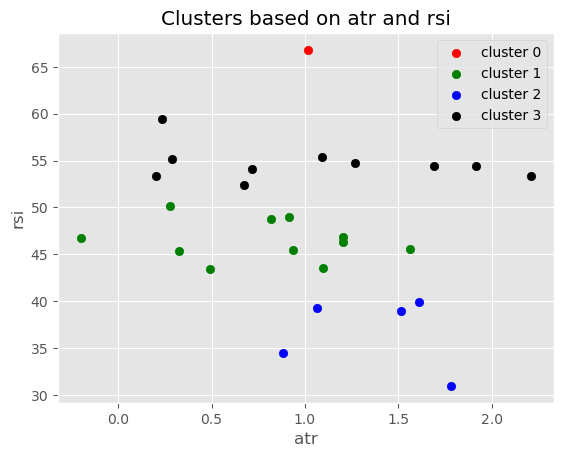

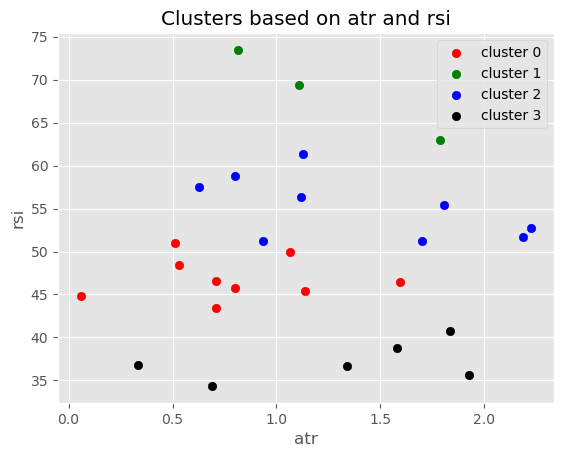

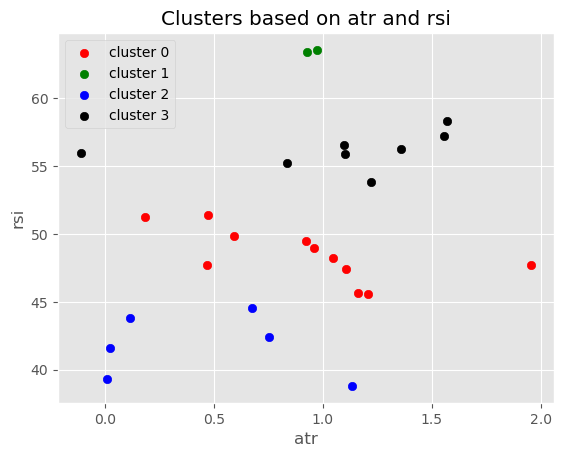

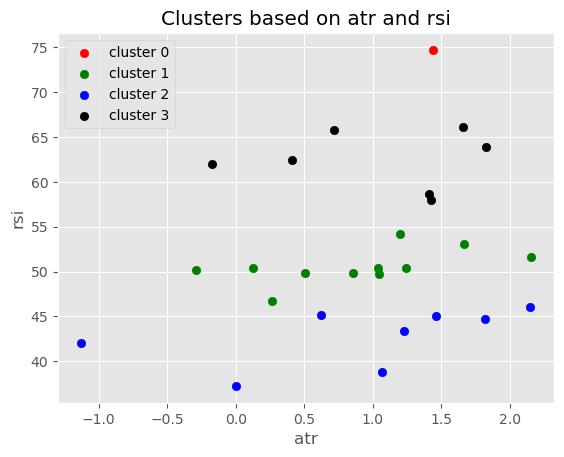

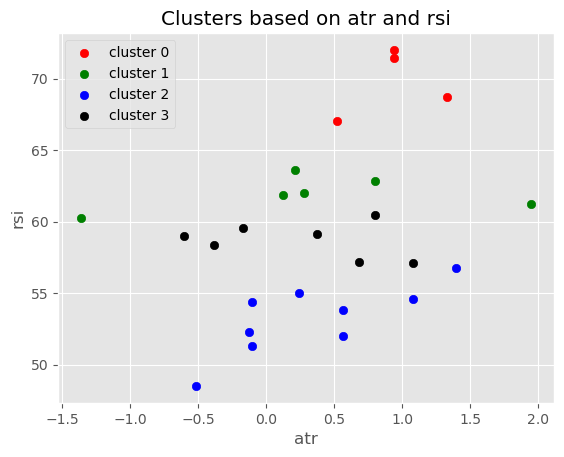

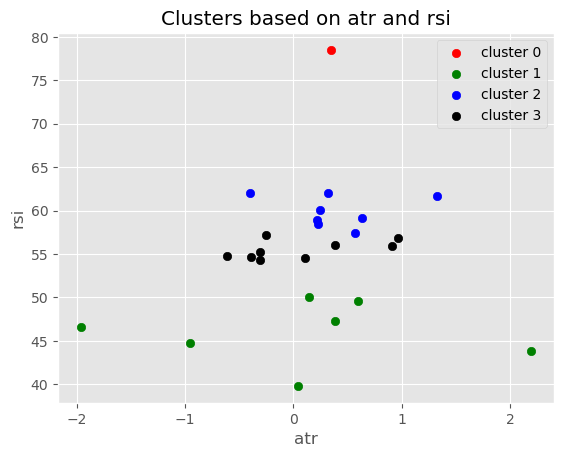

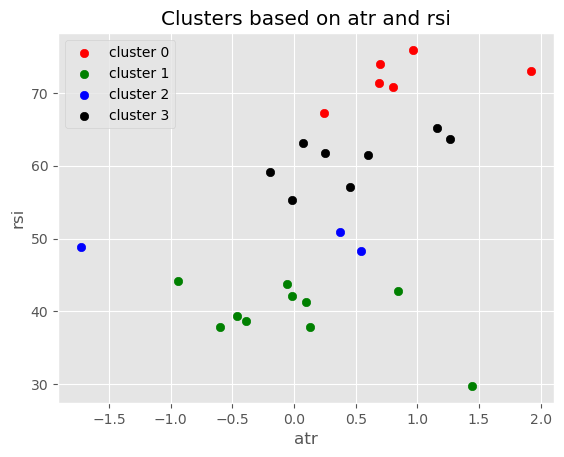

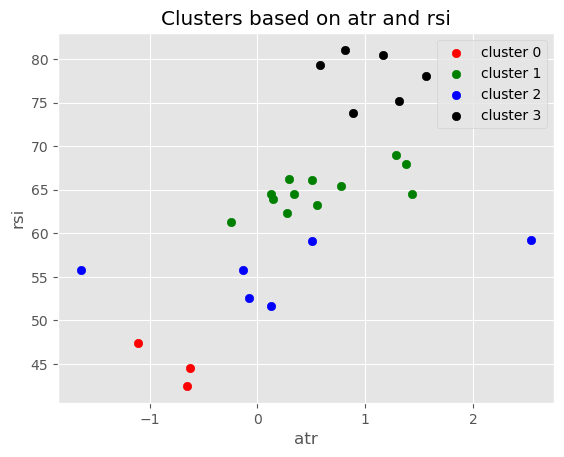

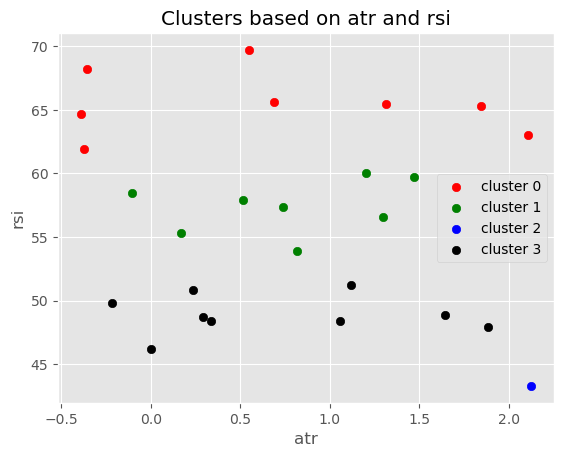

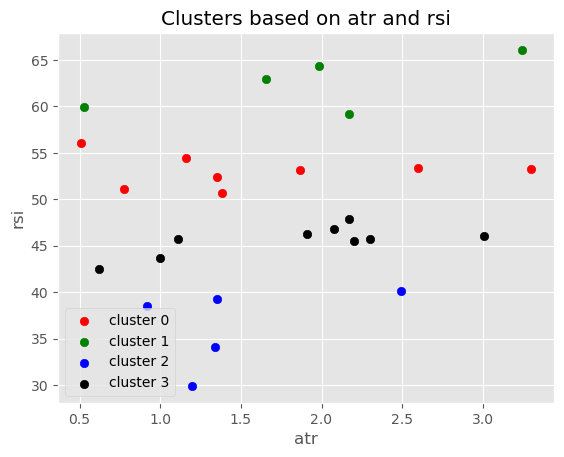

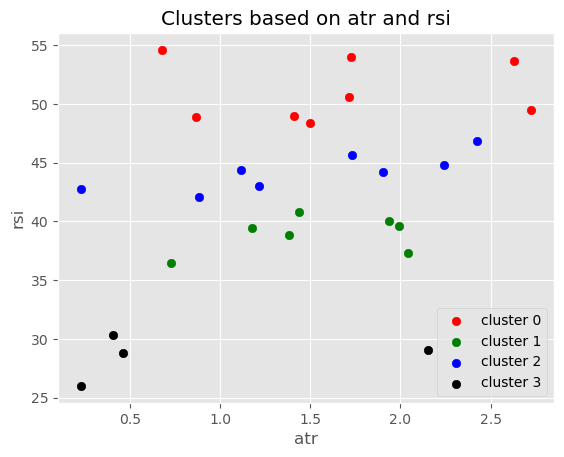

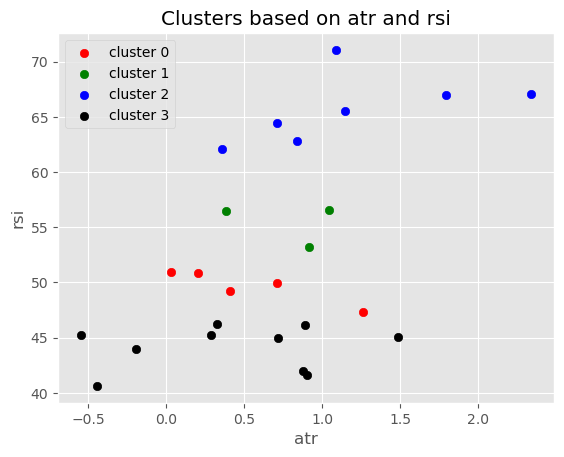

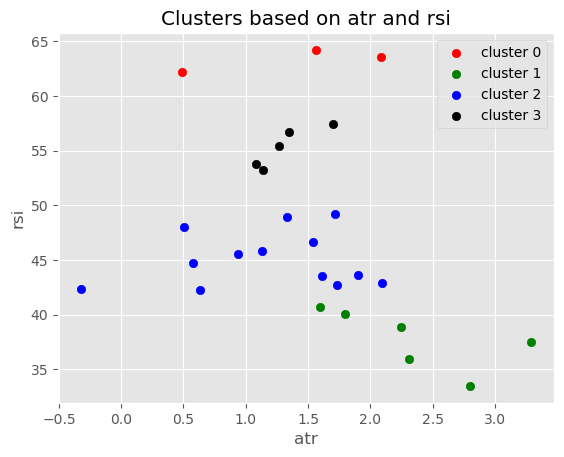

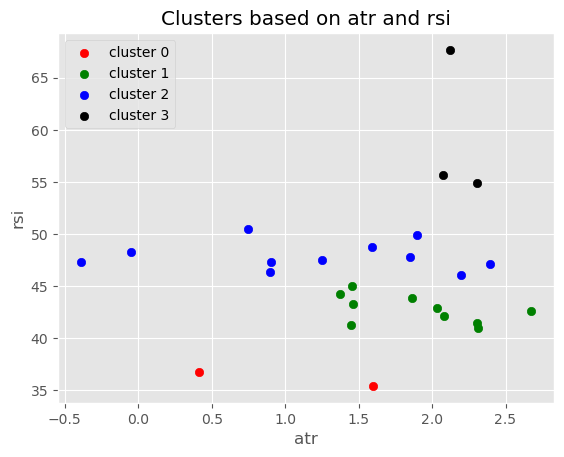

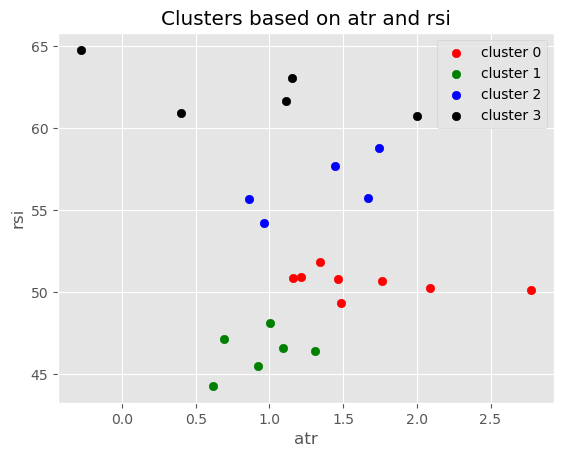

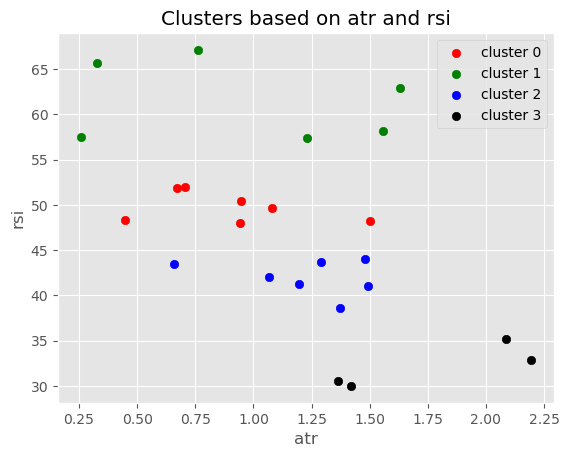

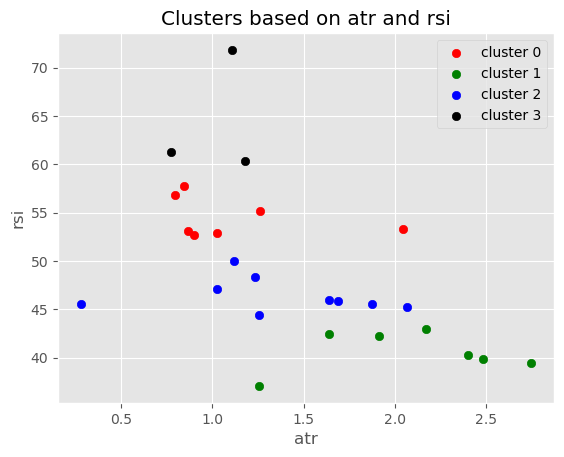

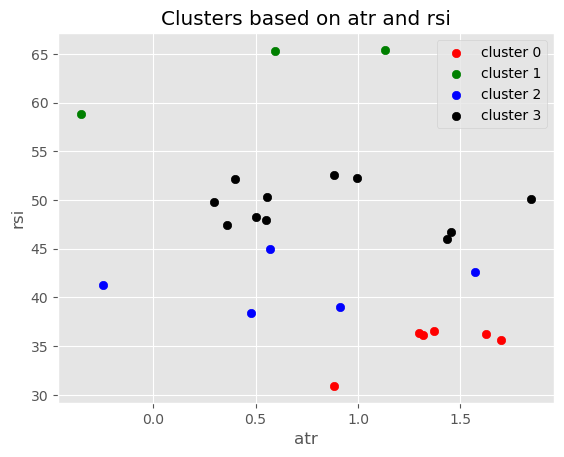

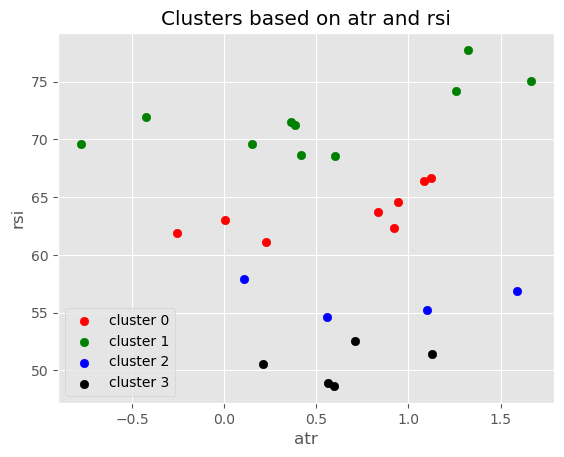

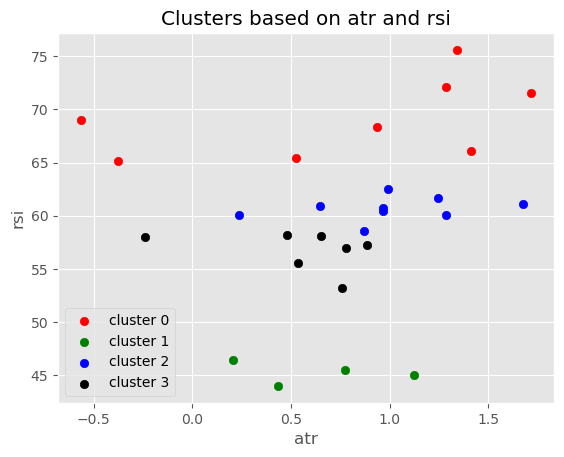

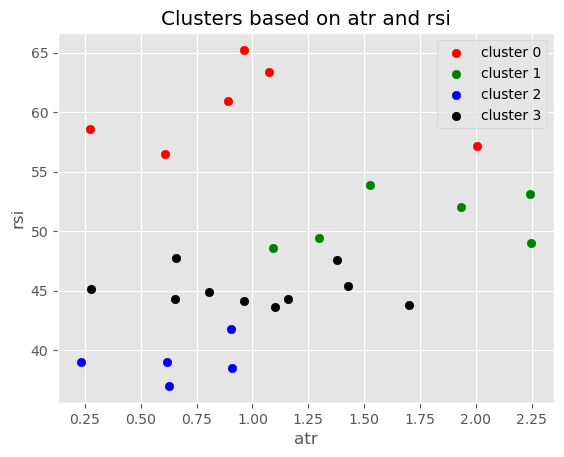

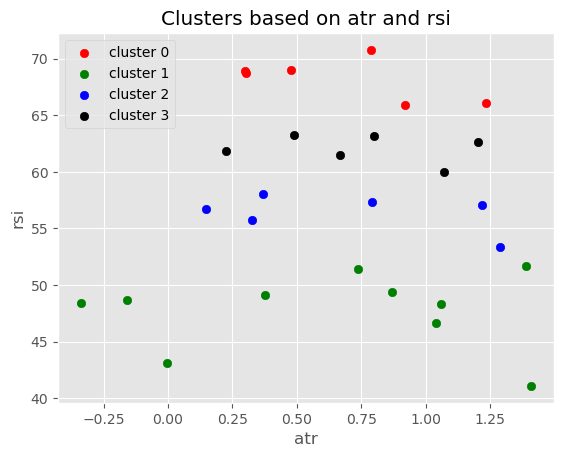

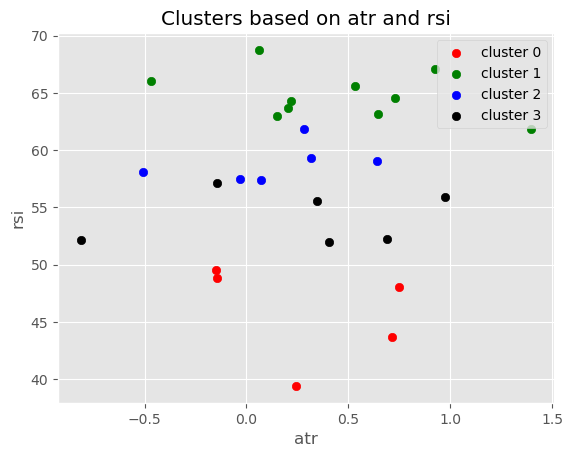

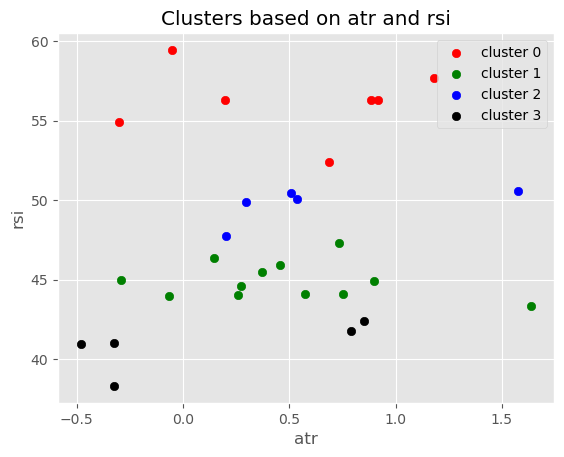

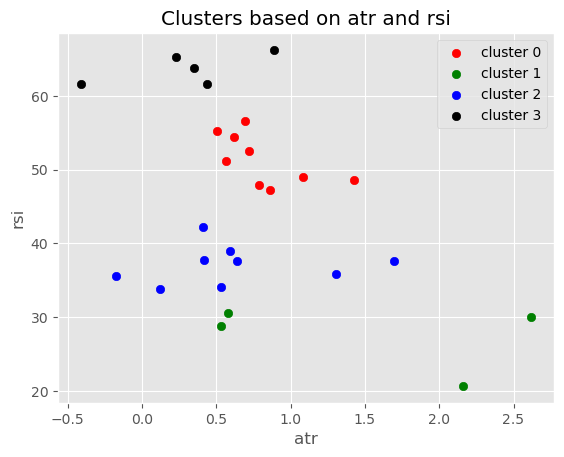

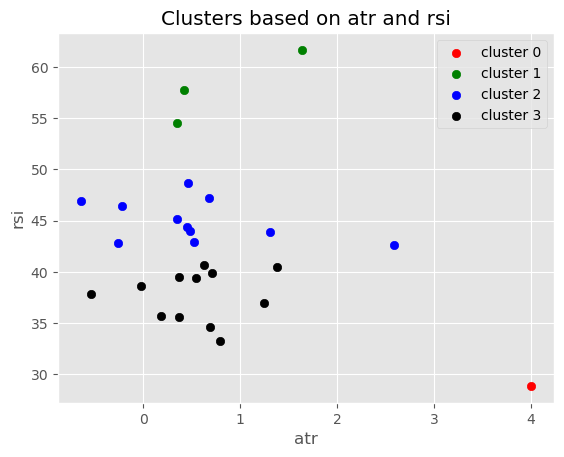

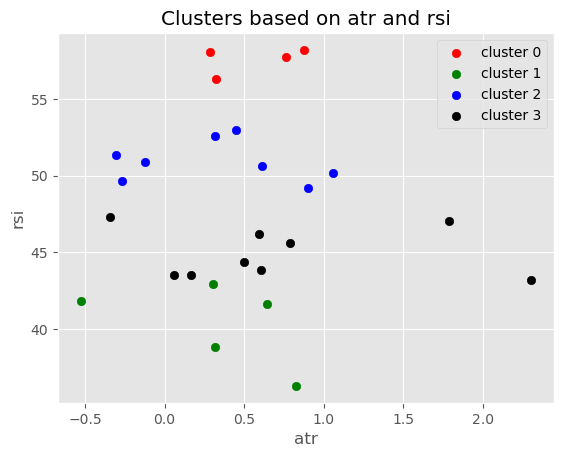

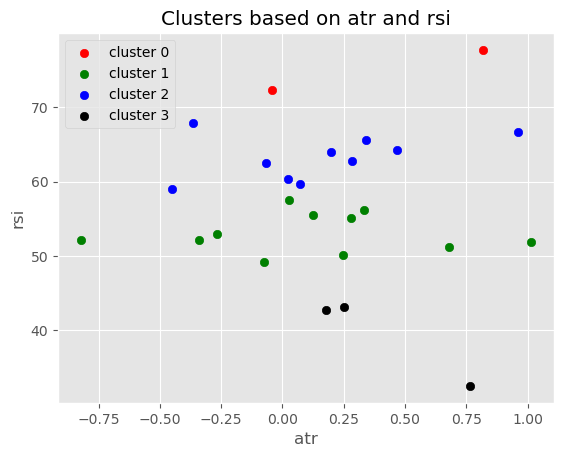

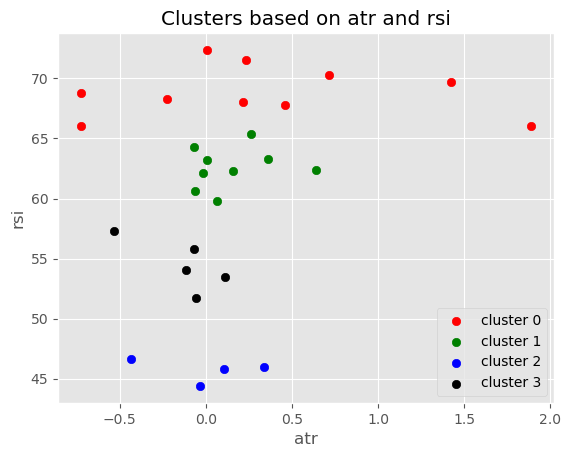

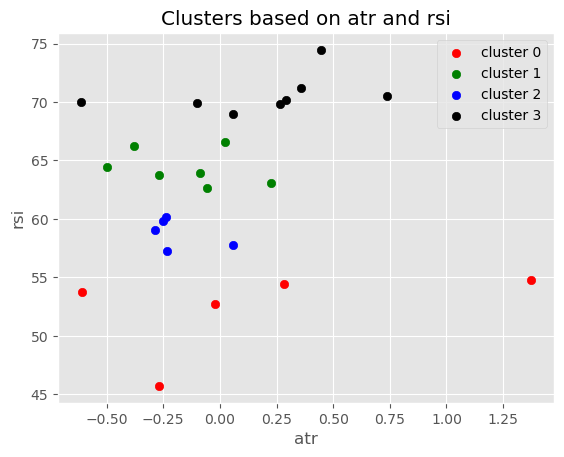

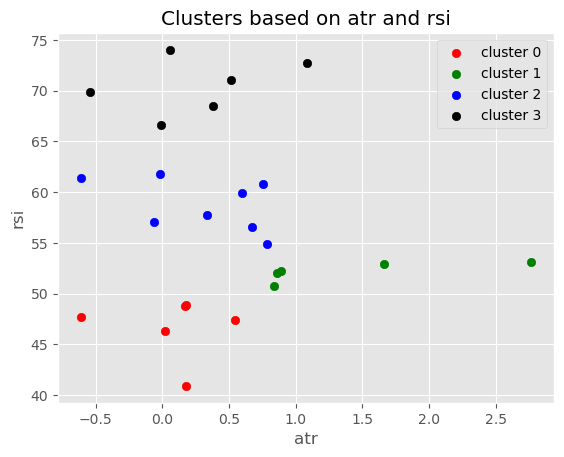

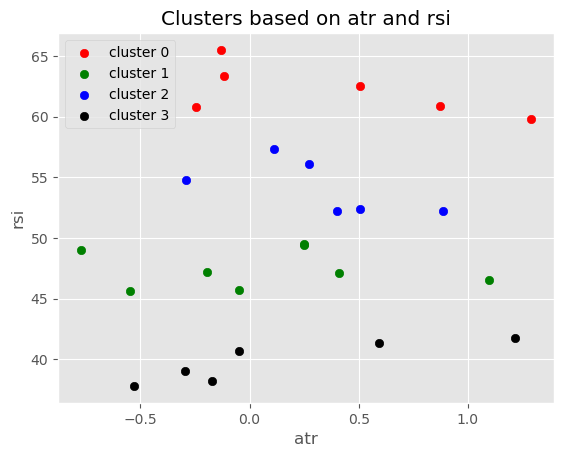

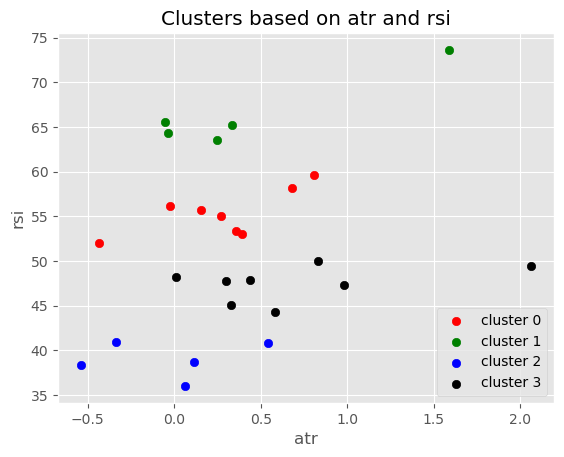

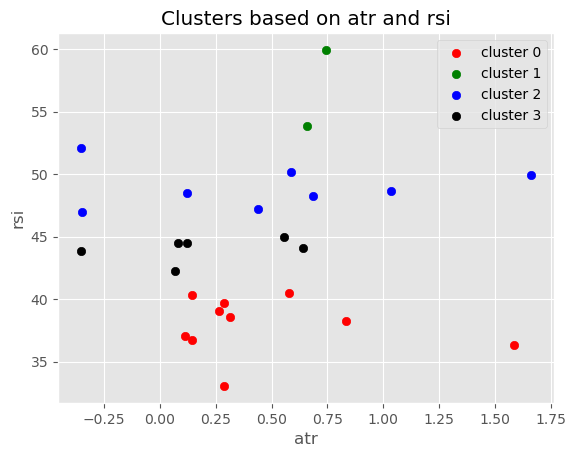

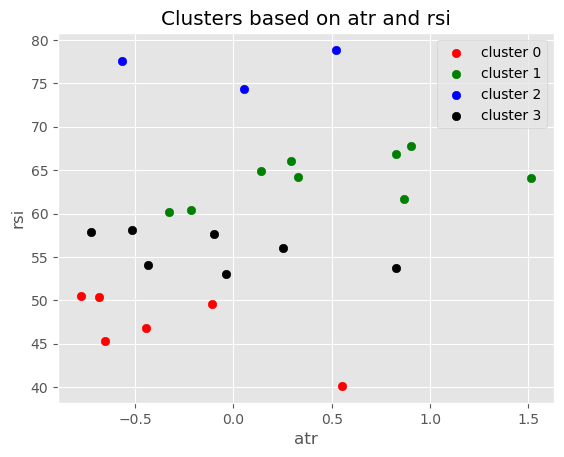

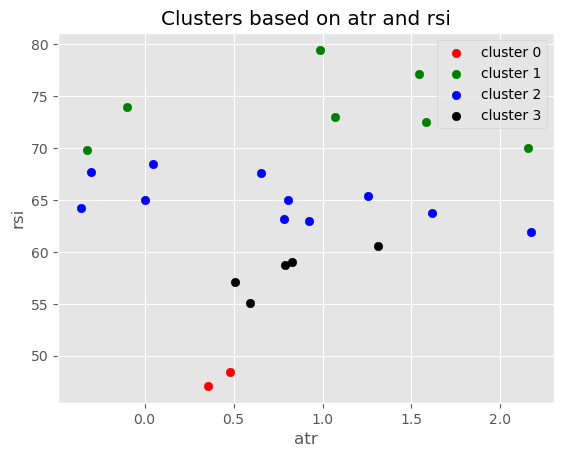

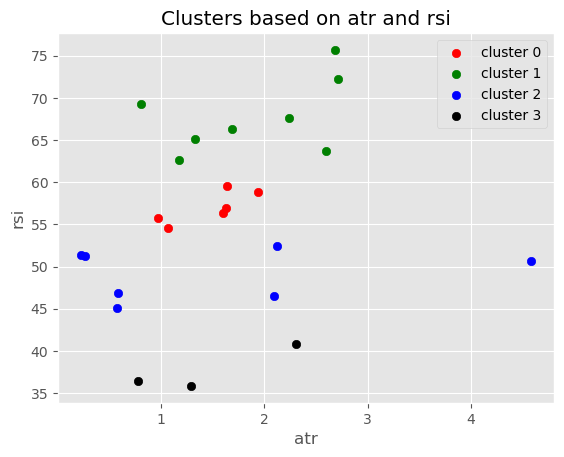

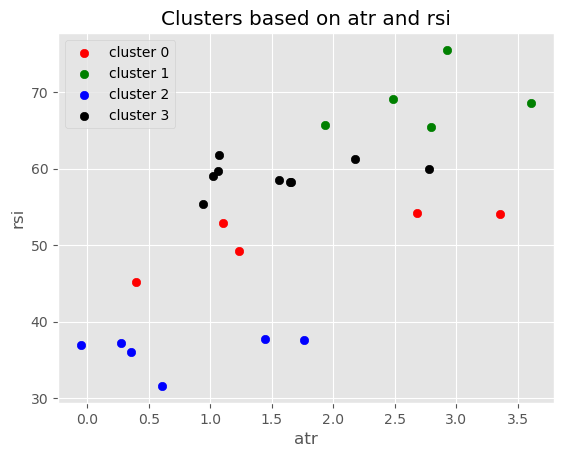

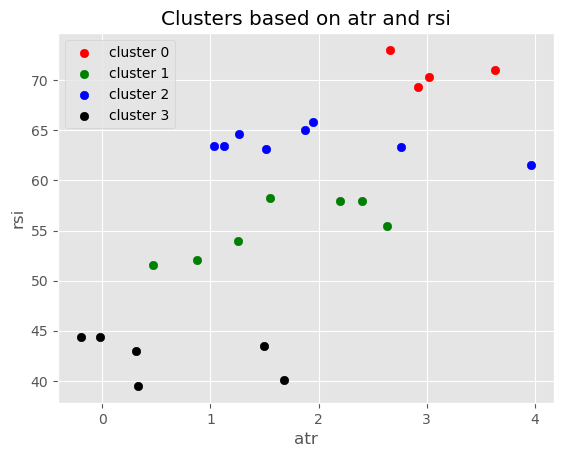

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-04-30 AXISBANK.NS            0.000178  53.415712  6.176689  6.210429   
           HDFCBANK.NS           -0.001161  73.350255  6.491661  6.553383   
           HINDALCO.NS            0.001572  58.105793  5.163354  5.216246   
           ICICIBANK.NS           0.000135  51.117142  5.465362  5.501072   
           INDUSINDBK.NS         -0.000946  61.816260  7.202458  7.226385   
...                                    ...        ...       ...       ...   
2024-03-31 SUNPHARMA.NS           0.000166  70.282065  7.288569  7.334556   
           TATAMOTORS.NS          0.000159  73.035404  6.803003  6.839862   
           TATASTEEL.NS           0.000488  63.192494  4.928721  4.966901   
           TCS.NS                 0.000080  58.259872  8.291248  8.315752   
           TITAN.NS               0.000278  57.901359  8.164501  8.195490   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-04-30 AXISBANK.NS    6.244168 -0.646374 -0.044190   0.038407   0.002956   
           HDFCBANK.NS    6.615105 -0.901571  0.761138   0.072060   0.054756   
           HINDALCO.NS    5.269138 -0.889097 -0.091142   0.022046   0.039888   
           ICICIBANK.NS   5.536782 -1.337058 -0.384067   0.005960   0.003883   
           INDUSINDBK.NS  7.250313 -0.911138  0.577870   0.013893   0.049205   
...                            ...       ...       ...        ...        ...   
2024-03-31 SUNPHARMA.NS   7.380543  3.019013  3.705632  -0.011851   0.187731   
           TATAMOTORS.NS  6.876722  2.655713  2.600015   0.028626   0.051383   
           TATASTEEL.NS   5.005082  1.517843  0.933730   0.064608   0.050228   
           TCS.NS         8.340256  1.547052  1.159520  -0.000183   0.035836   
           TITAN.NS       8.226478  2.399310 -0.268556   0.078869   0.093608   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-04-30 AXISBANK.NS     0.030296   0.007640  -0.007656    0.007126   
           HDFCBANK.NS     0.063236   0.034867   0.024278    0.027015   
           HINDALCO.NS     0.016231   0.048954   0.046256    0.063028   
           ICICIBANK.NS    0.011699   0.000991   0.006425    0.015277   
           INDUSINDBK.NS   0.048923   0.031472   0.023182    0.027412   
...                             ...        ...        ...         ...   
2024-03-31 SUNPHARMA.NS    0.143815   0.079382   0.070639    0.054749   
           TATAMOTORS.NS   0.078124   0.075885   0.056954    0.073031   
           TATASTEEL.NS    0.024127   0.025531   0.032954    0.033312   
           TCS.NS          0.027357   0.026326   0.025293    0.022059   
           TITAN.NS        0.066501   0.049754   0.053042    0.029899   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-04-30 AXISBANK.NS    0.840137  0.206854  0.417771 -0.406144  0.041846   
           HDFCBANK.NS    0.462479  0.394104  0.200474  0.003533  0.154663   
           HINDALCO.NS    0.566076 -0.054949  1.514378 -1.341197 -1.412839   
           ICICIBANK.NS   0.709317 -0.596395  0.797990 -0.262552 -0.427731   
           INDUSINDBK.NS  1.027926  0.277441  0.420714 -1.010002 -0.042659   
...                            ...       ...       ...       ...       ...   
2024-03-31 SUNPHARMA.NS   1.283282 -0.587462 -0.646838 -0.115942  0.169477   
           TATAMOTORS.NS  1.272673  0.496451  0.941781  0.732124 -0.641652   
           TATASTEEL.NS   1.140259 -0.170260  0.664365 -0.139141 -0.609095   
           TCS.NS         0.438545  0.029909 -0.108676 -0.189796  0.129571   
           TITAN.NS       1.053662 -2.563038  1.986501 -0.099843 -2.923462   

                  

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

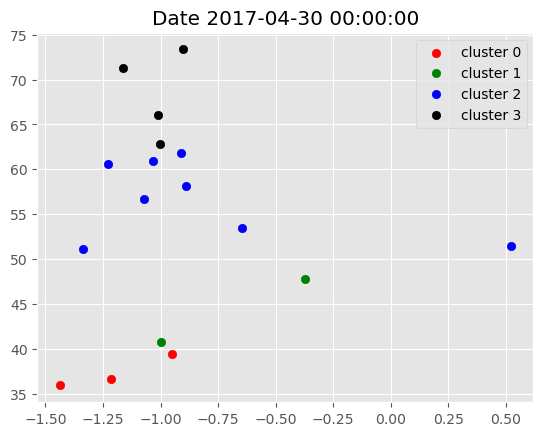

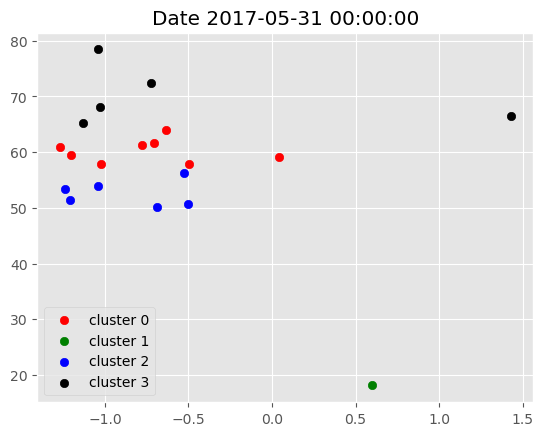

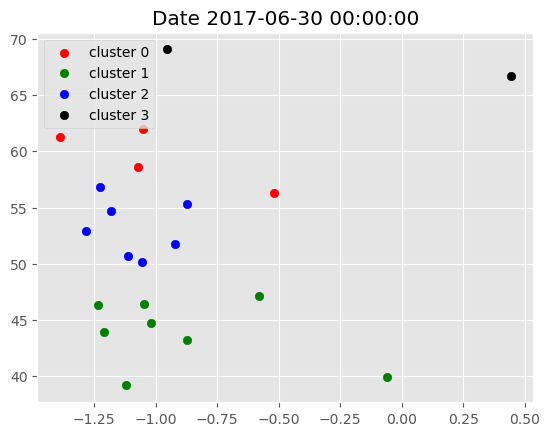

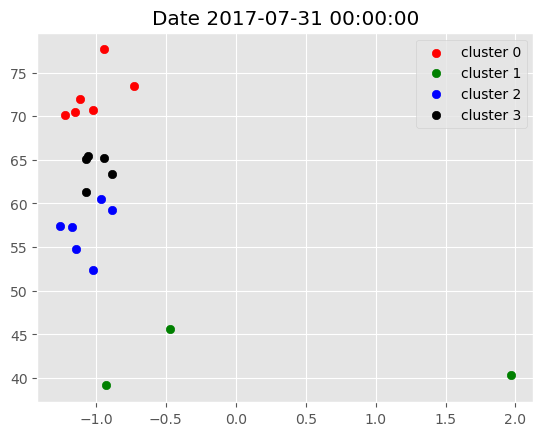

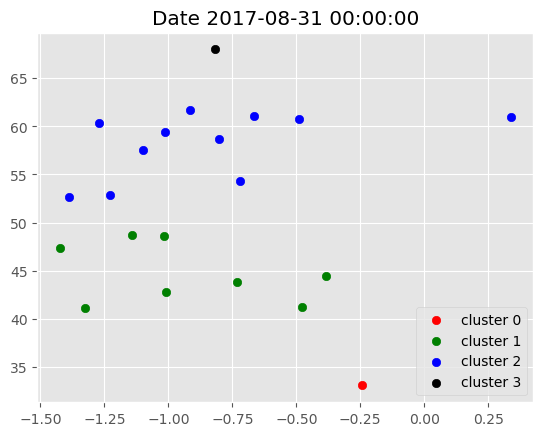

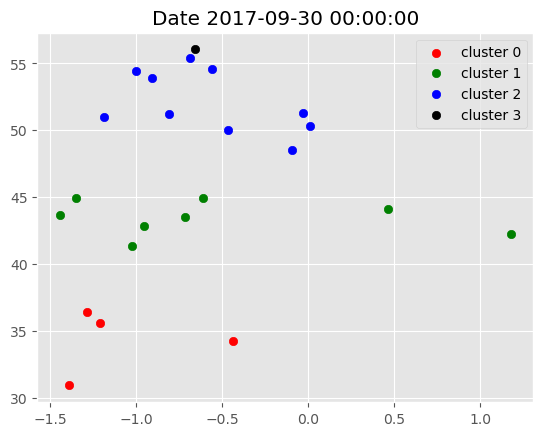

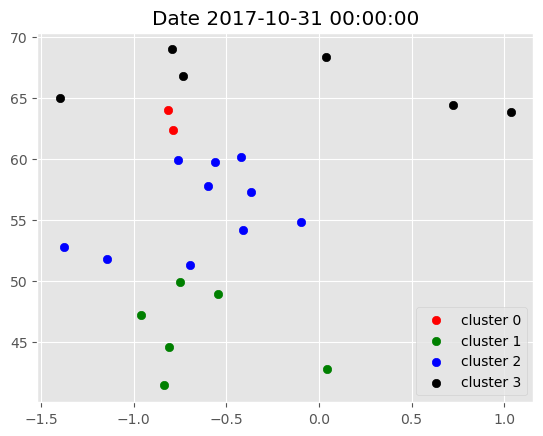

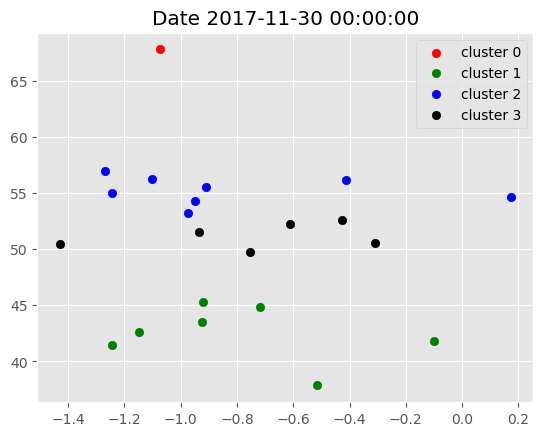

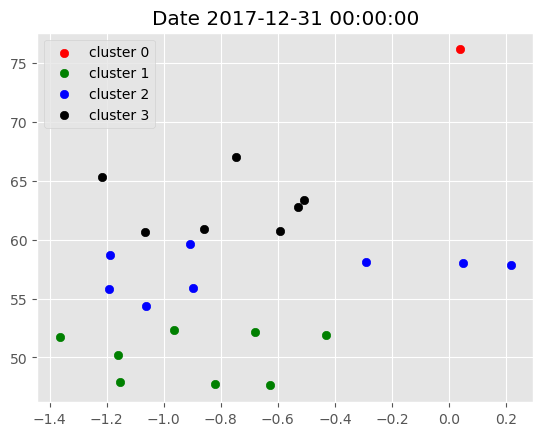

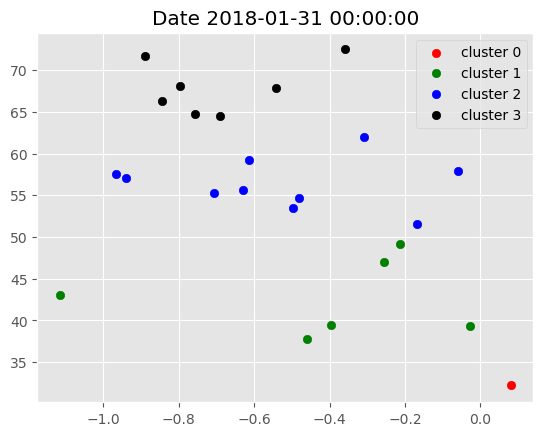

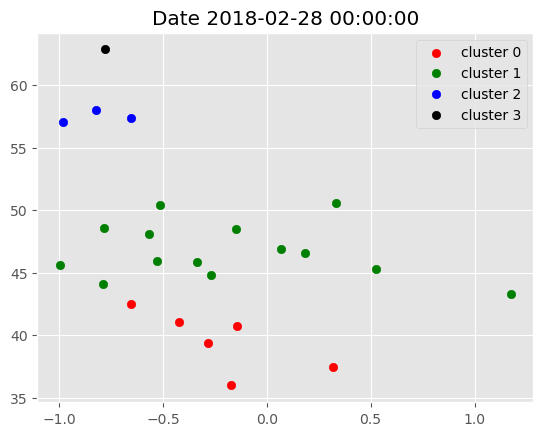

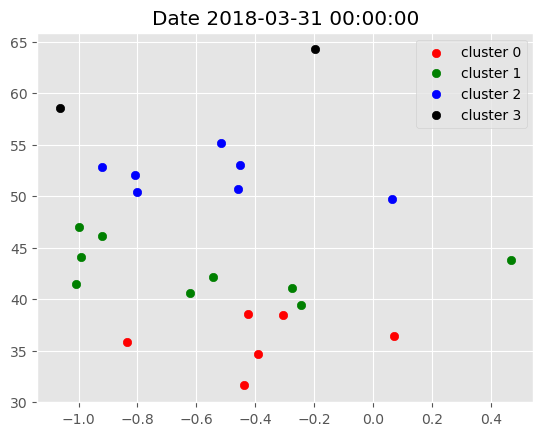

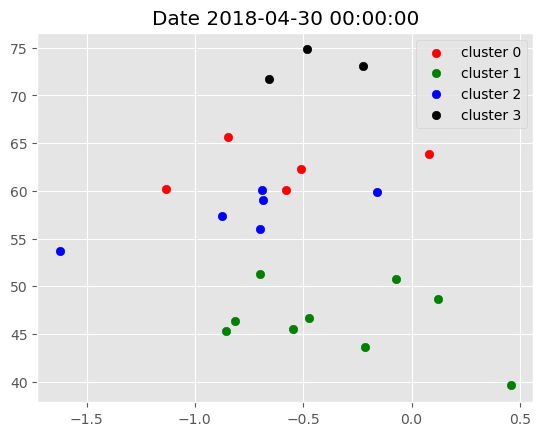

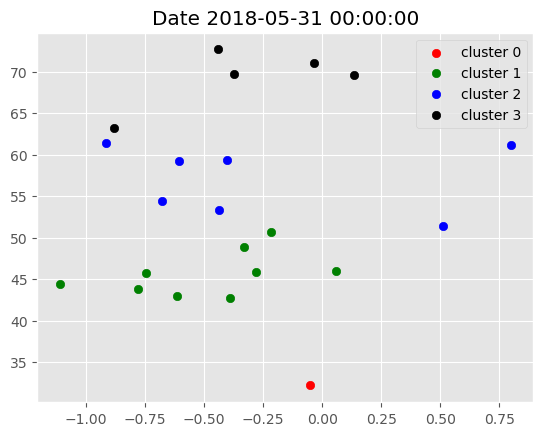

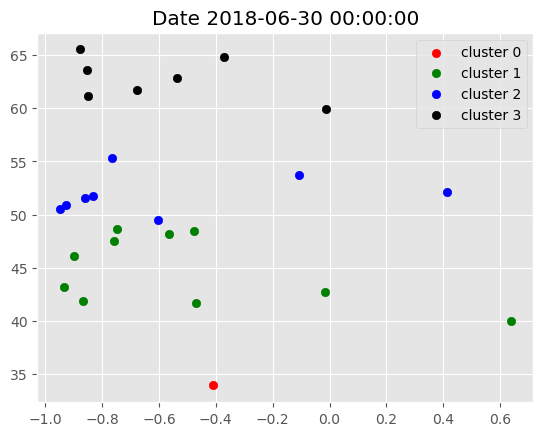

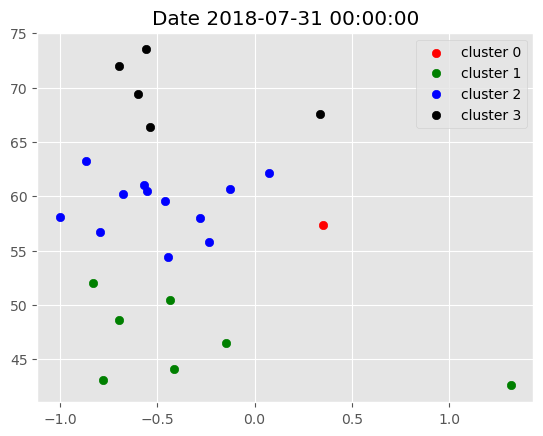

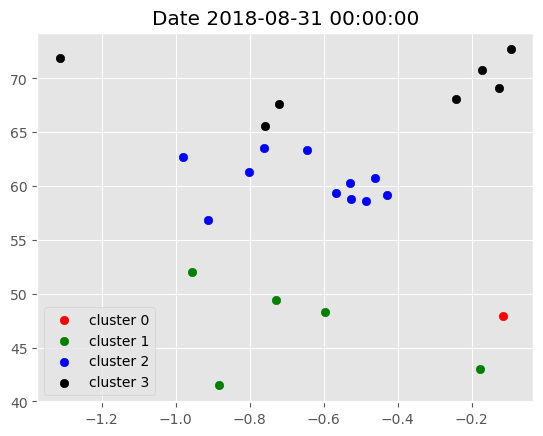

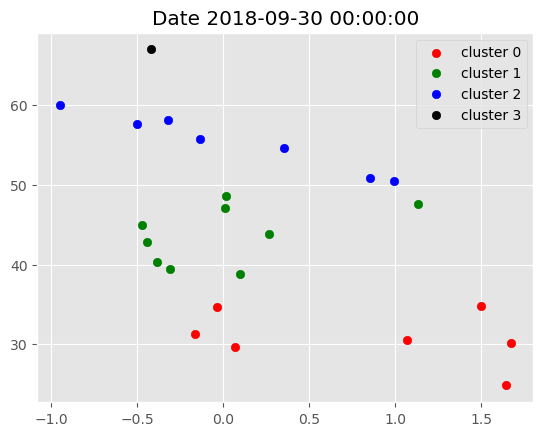

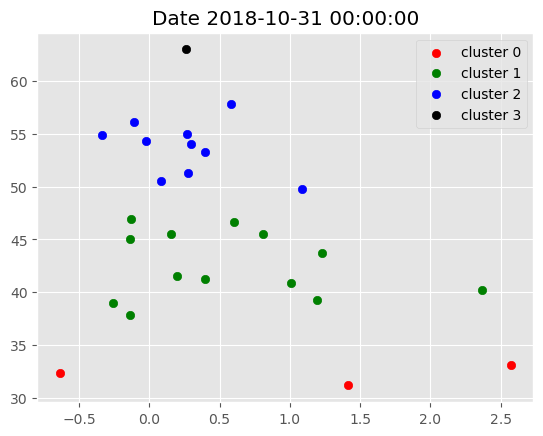

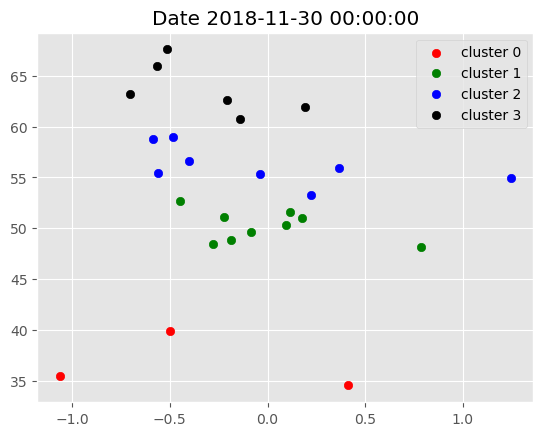

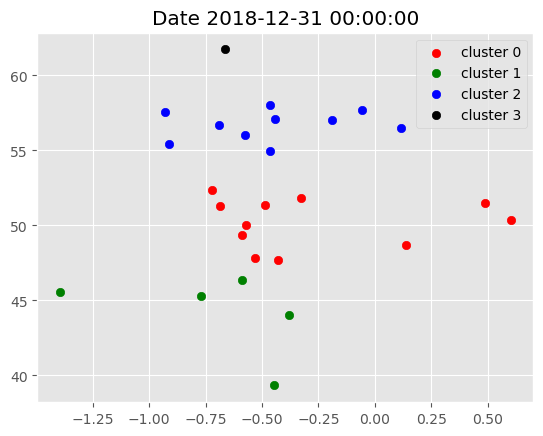

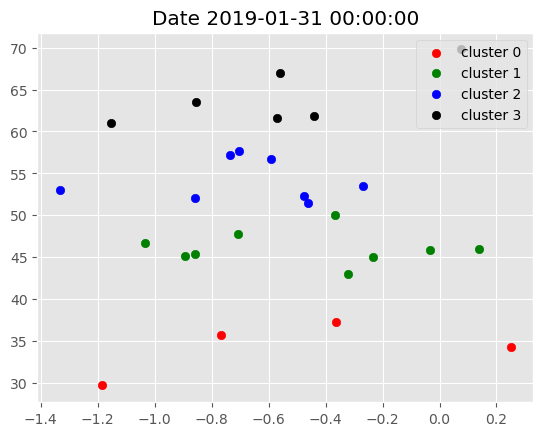

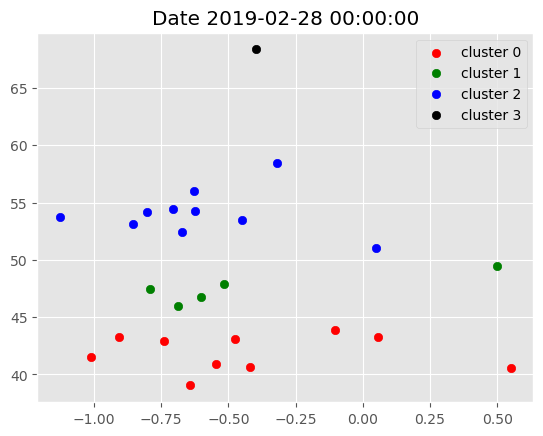

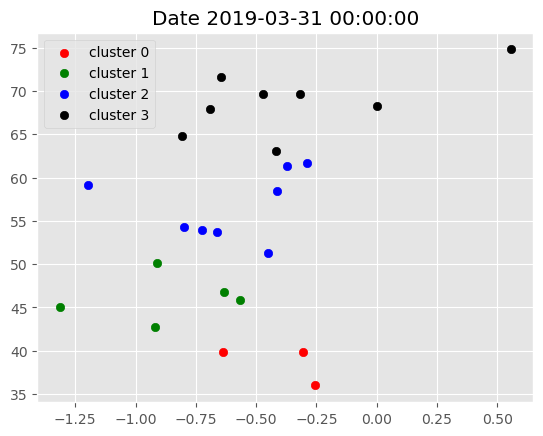

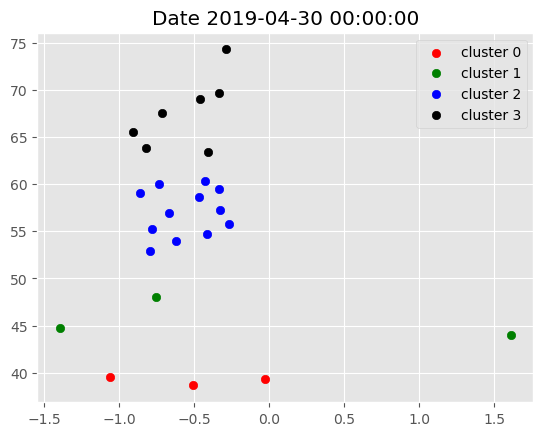

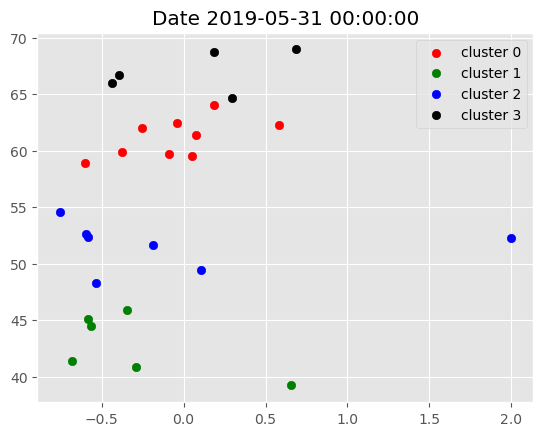

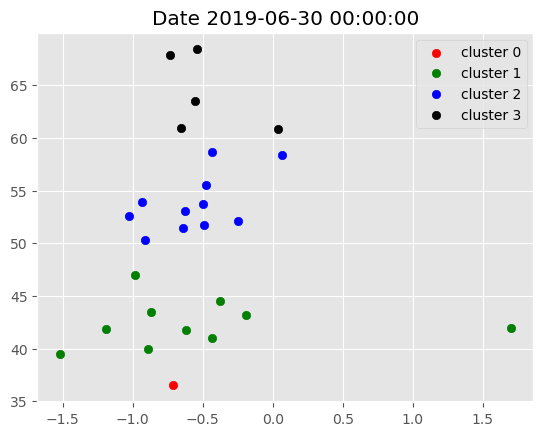

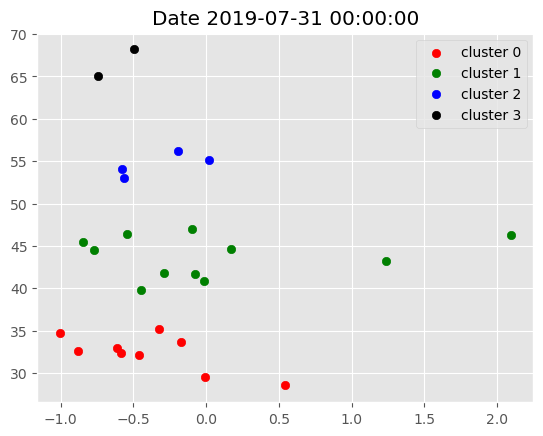

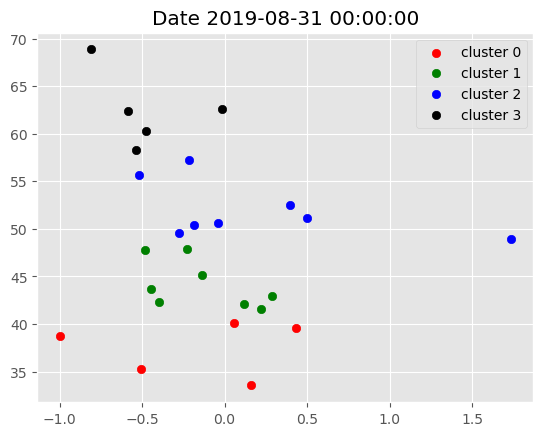

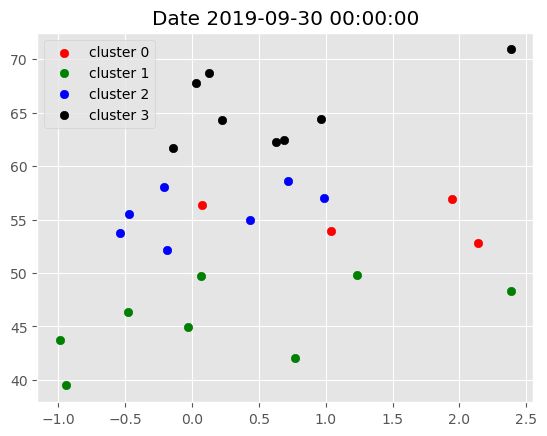

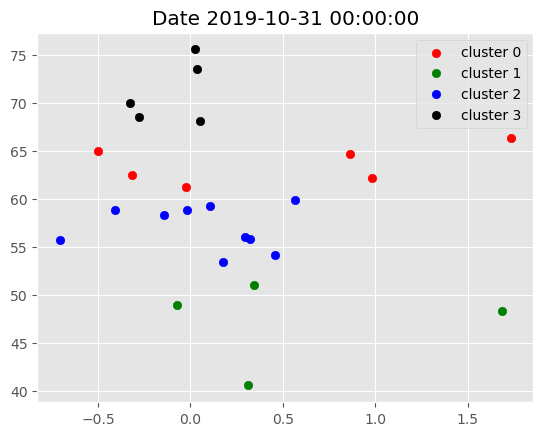

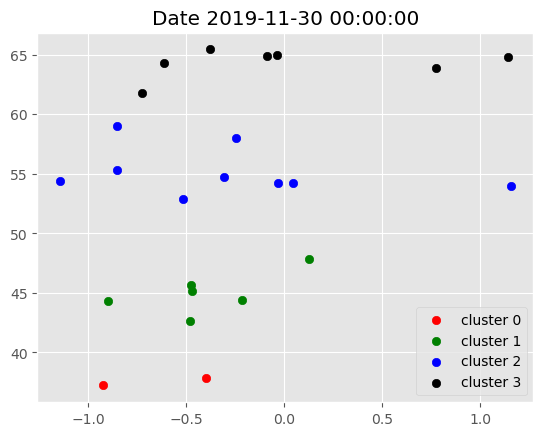

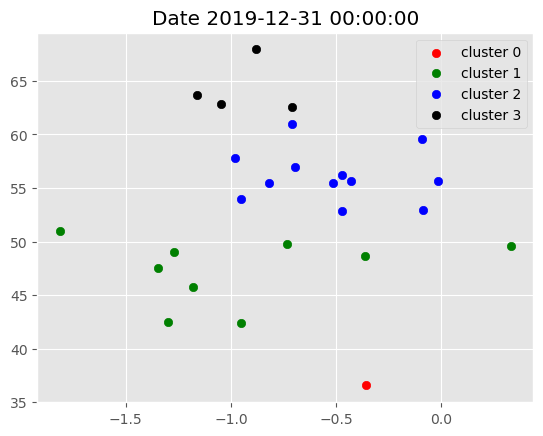

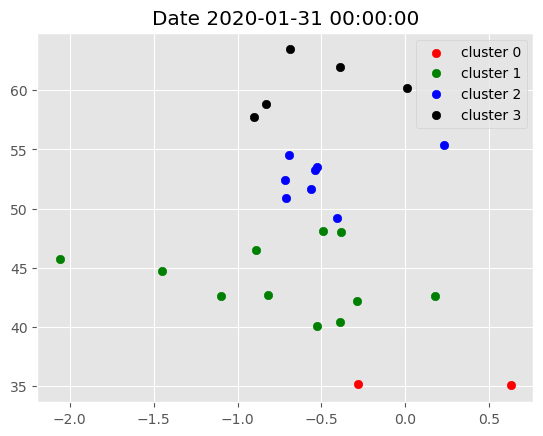

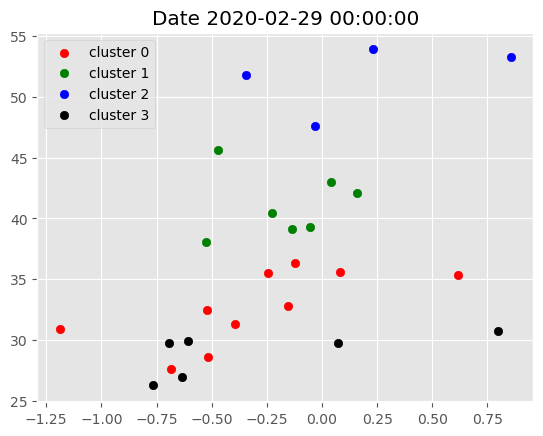

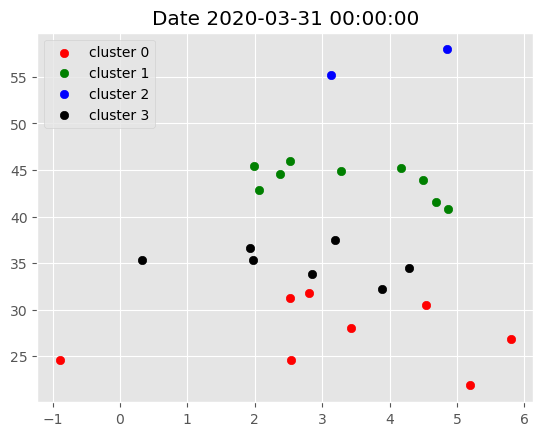

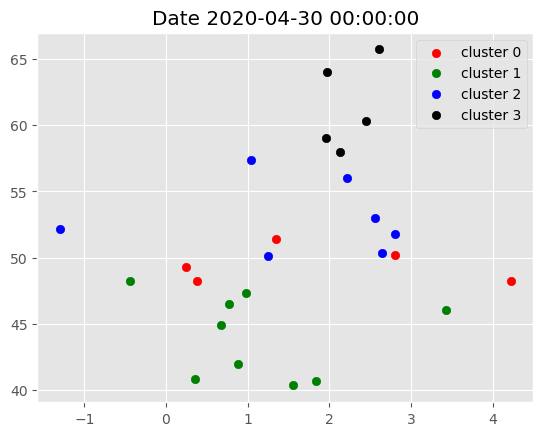

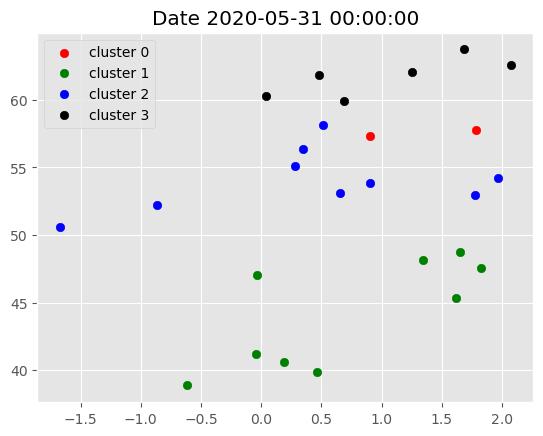

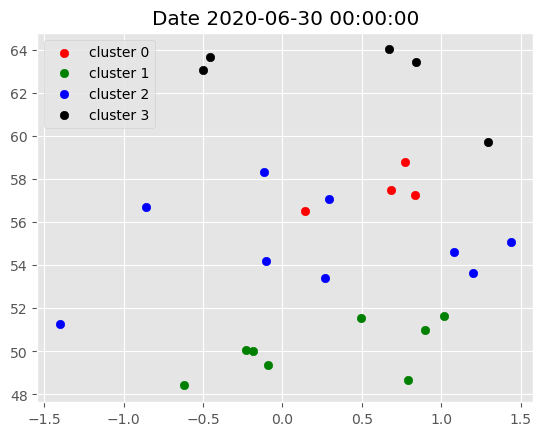

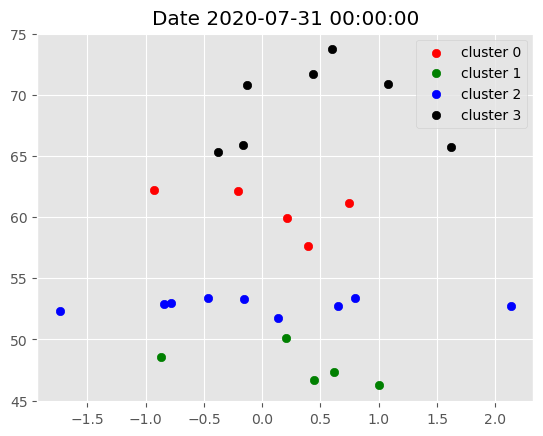

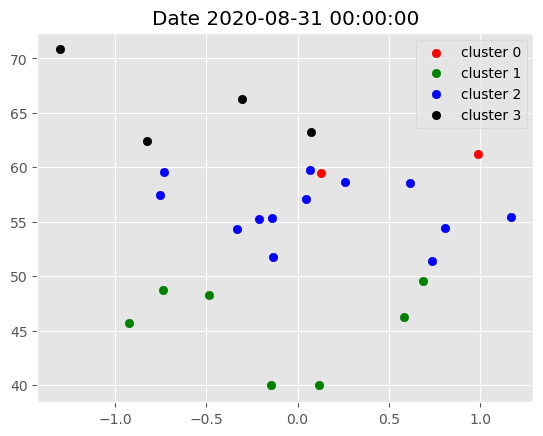

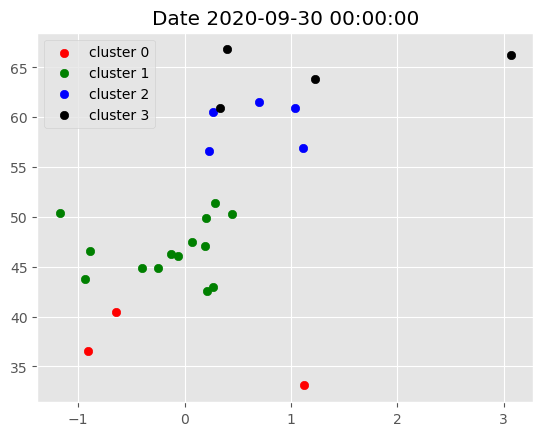

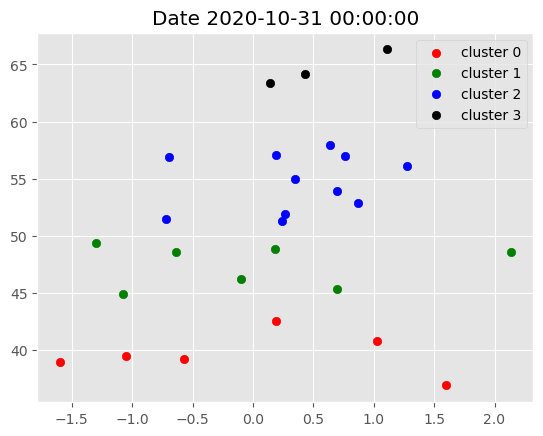

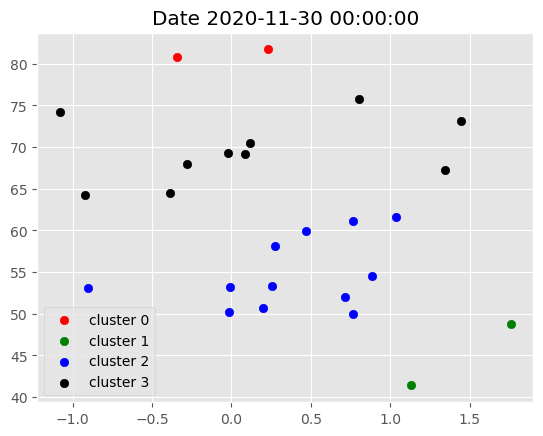

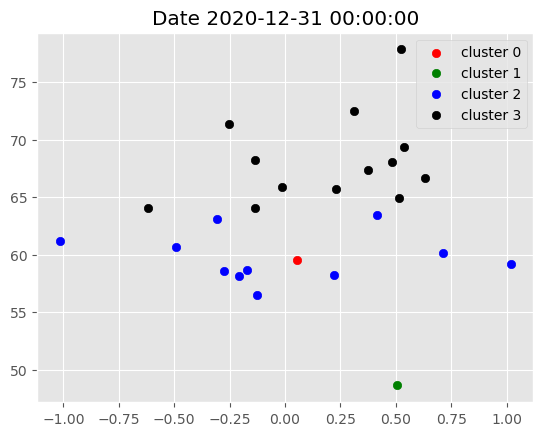

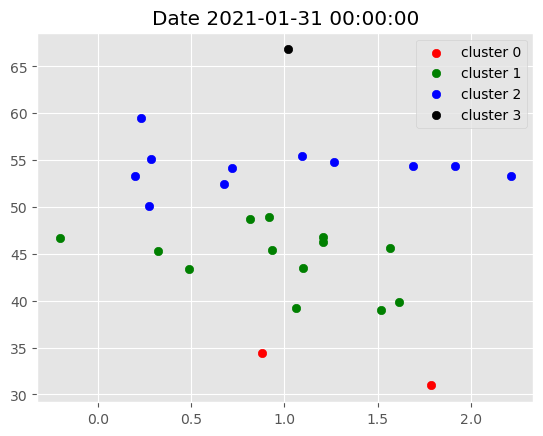

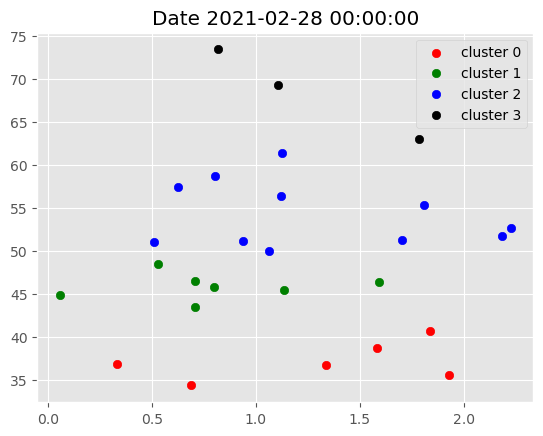

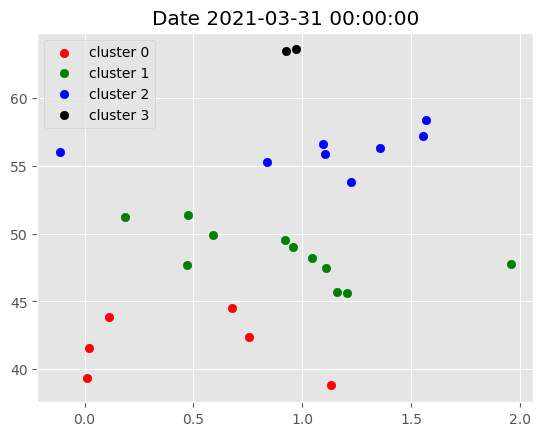

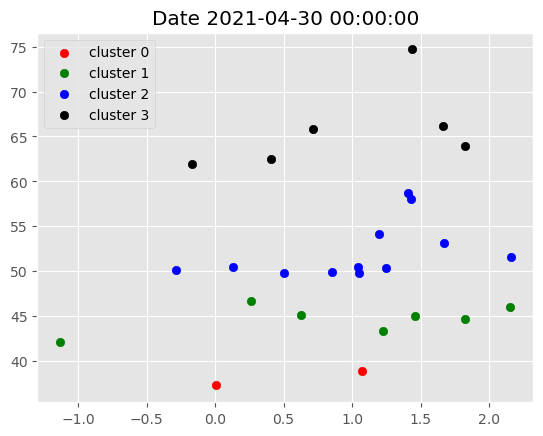

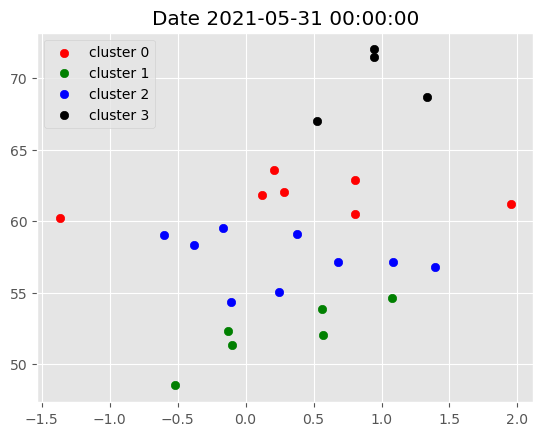

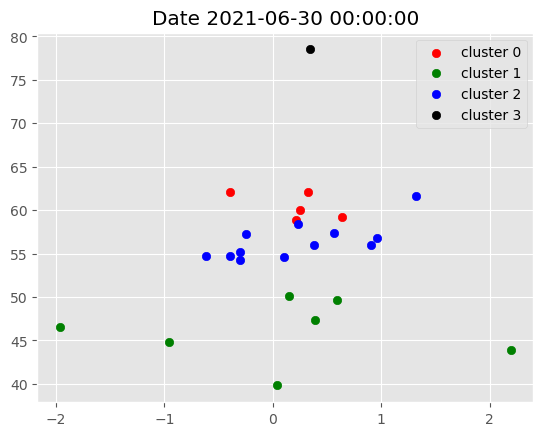

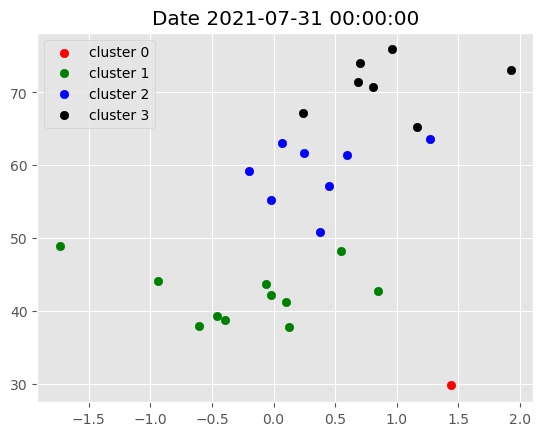

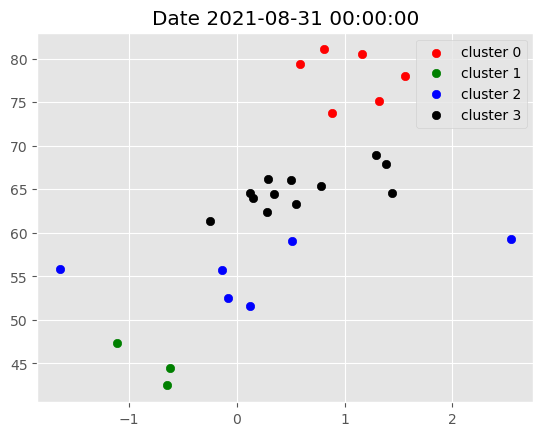

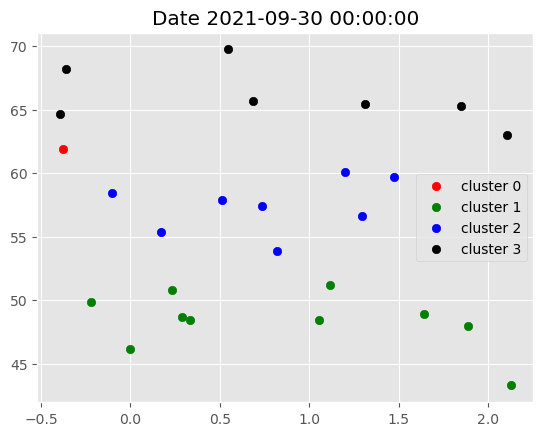

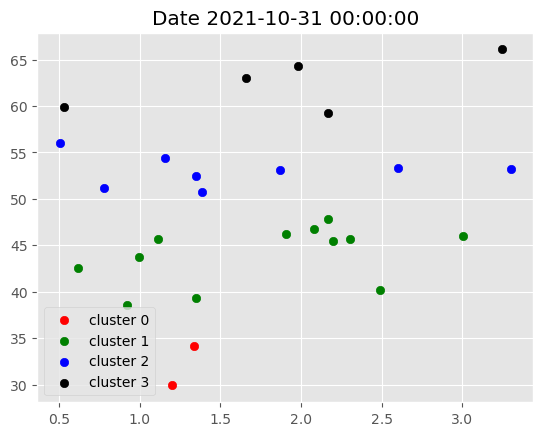

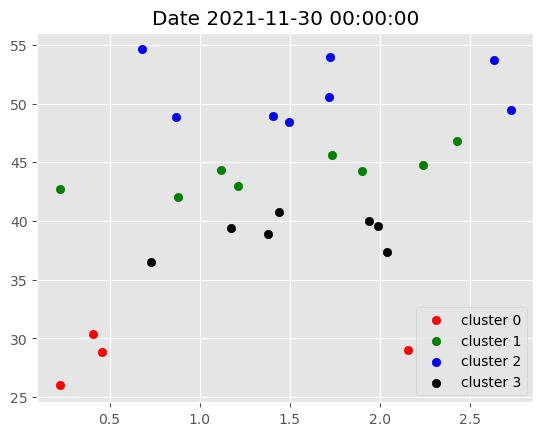

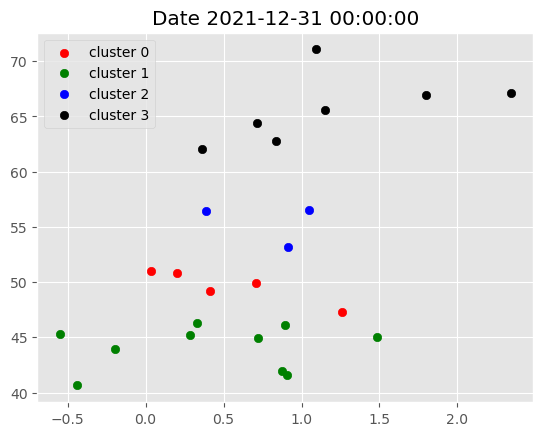

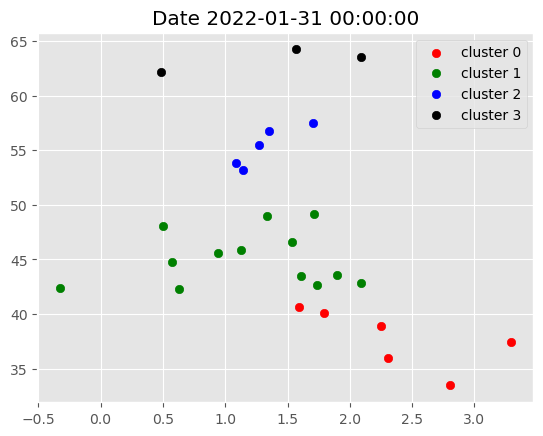

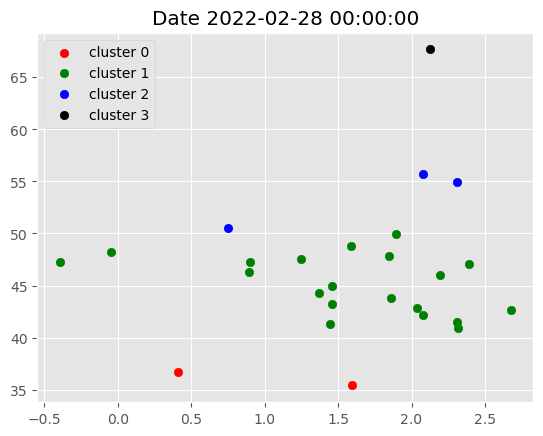

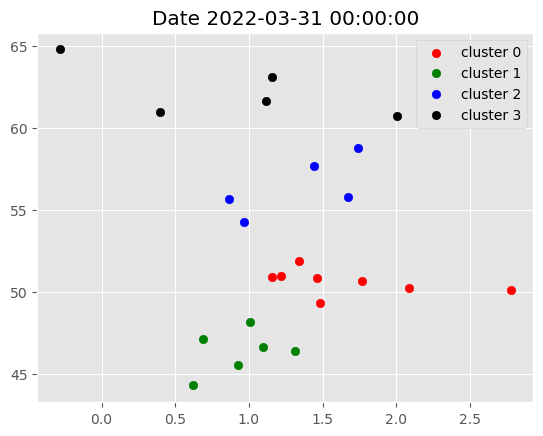

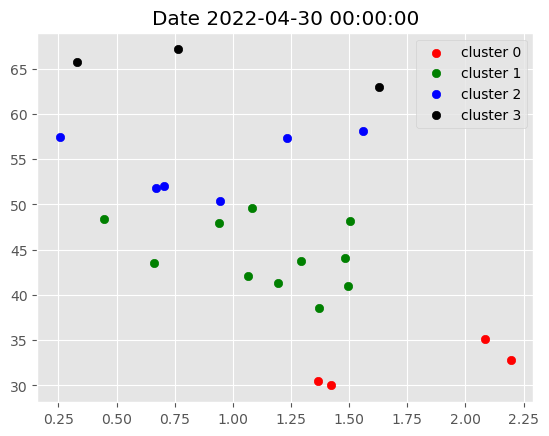

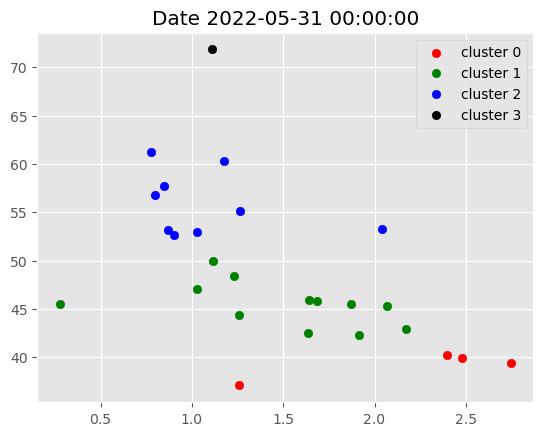

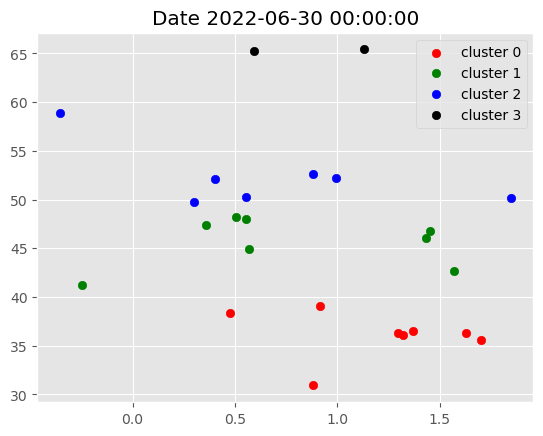

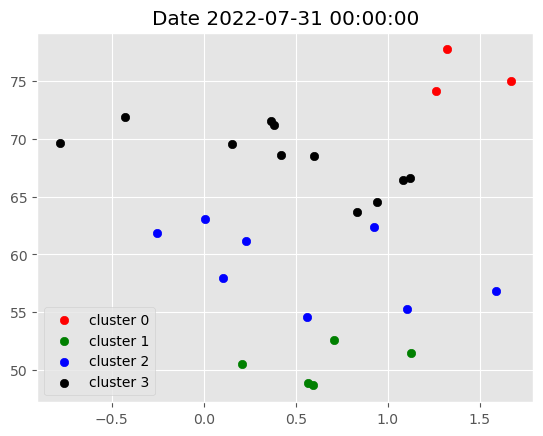

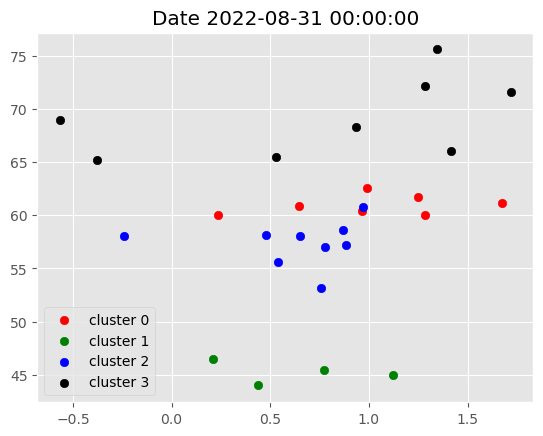

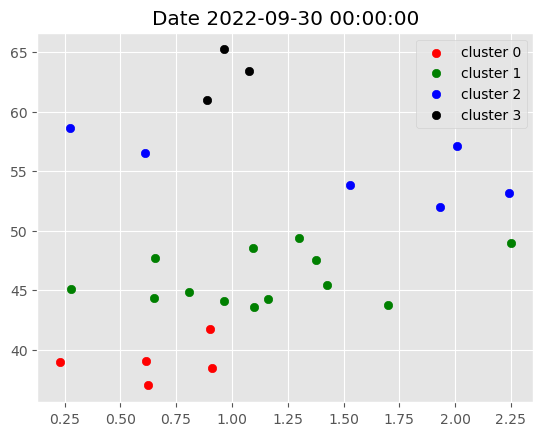

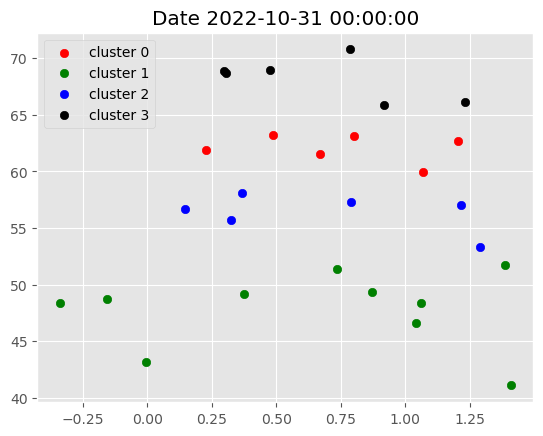

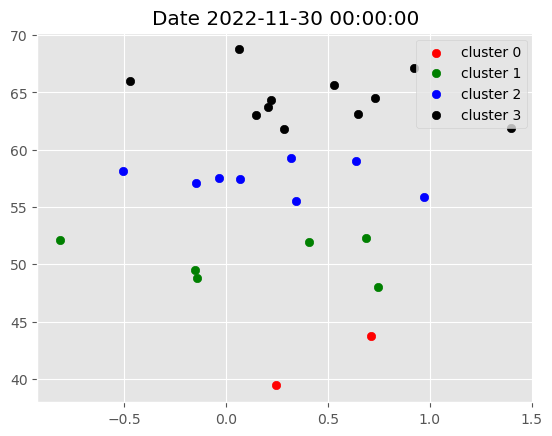

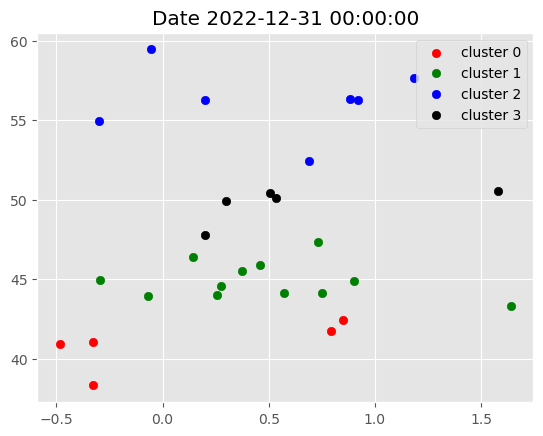

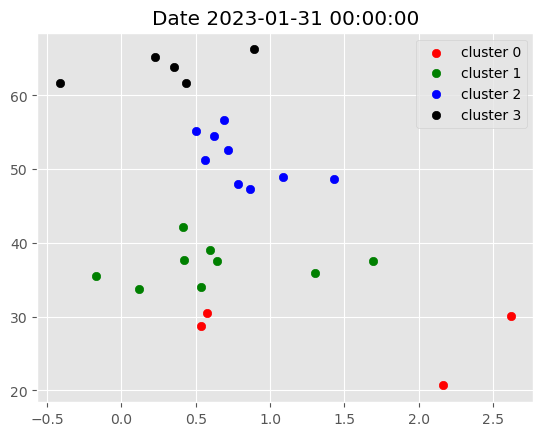

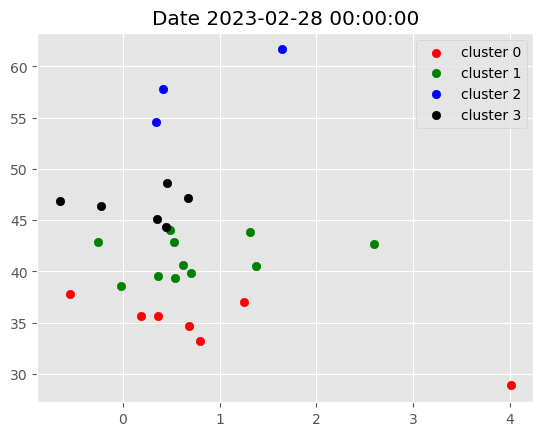

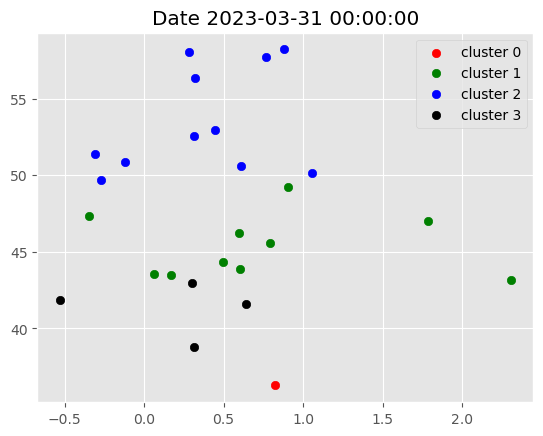

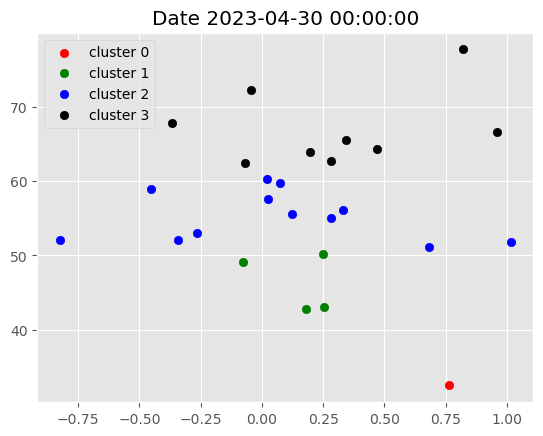

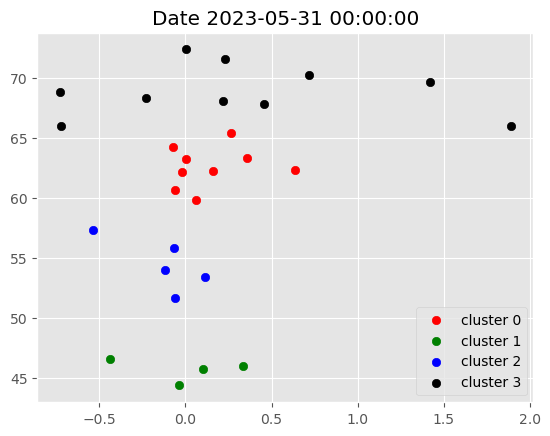

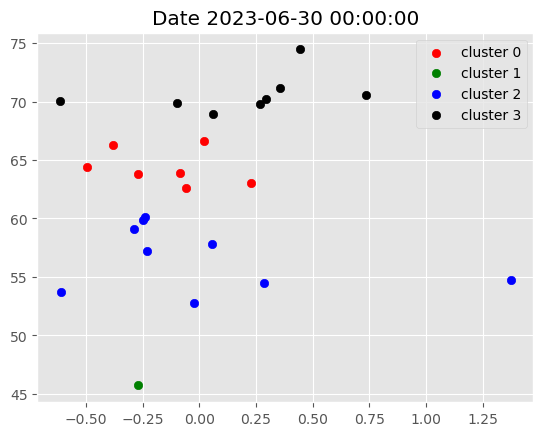

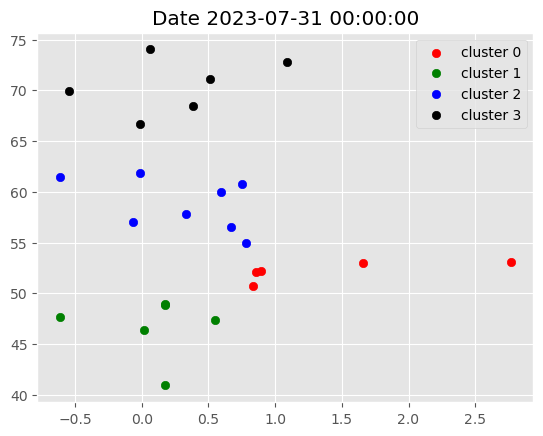

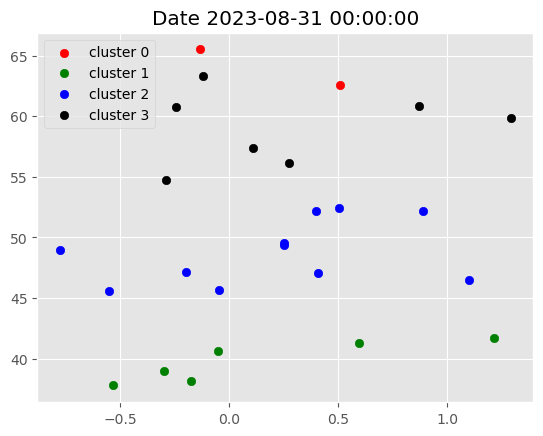

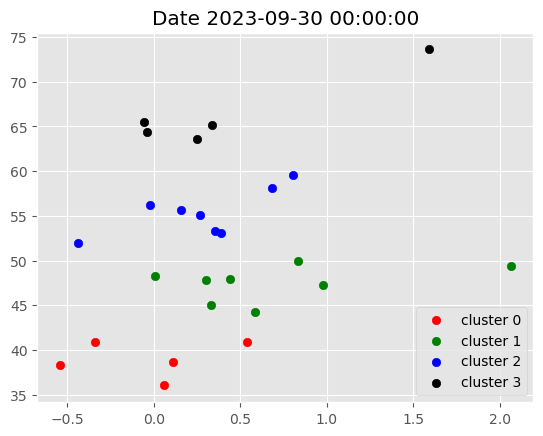

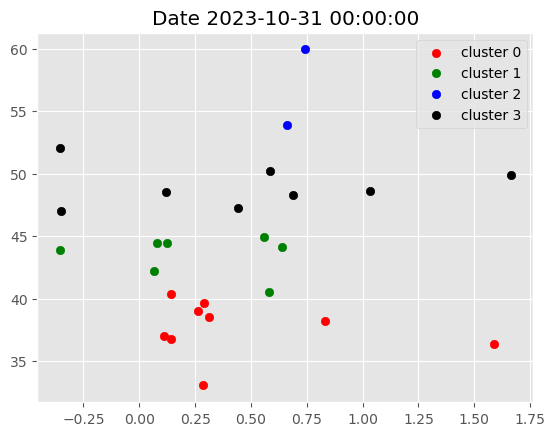

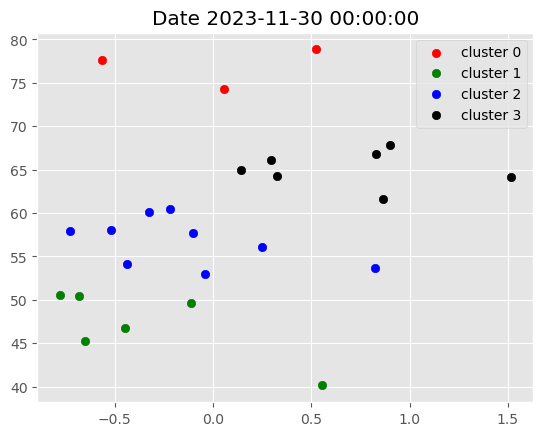

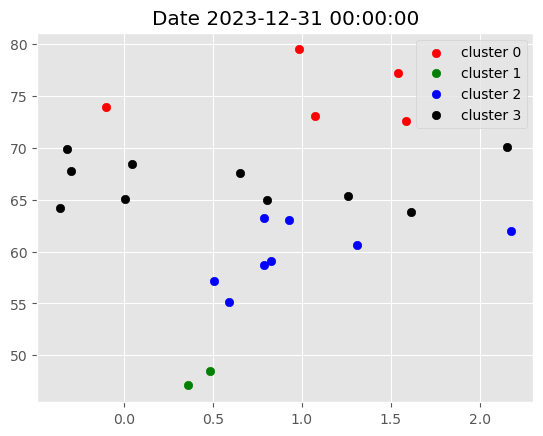

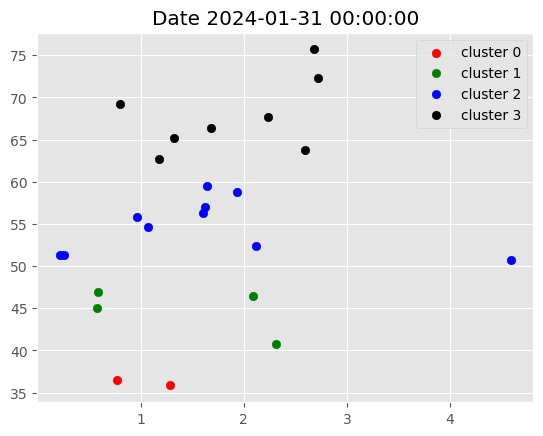

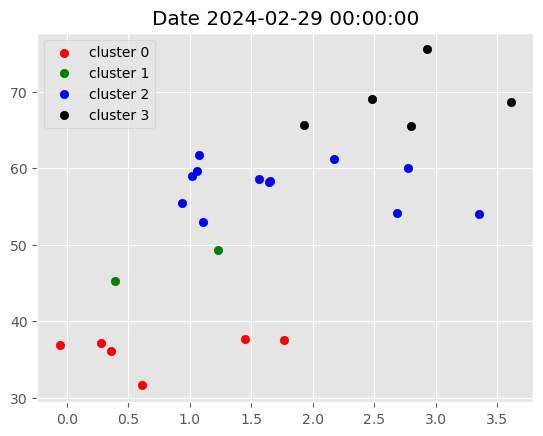

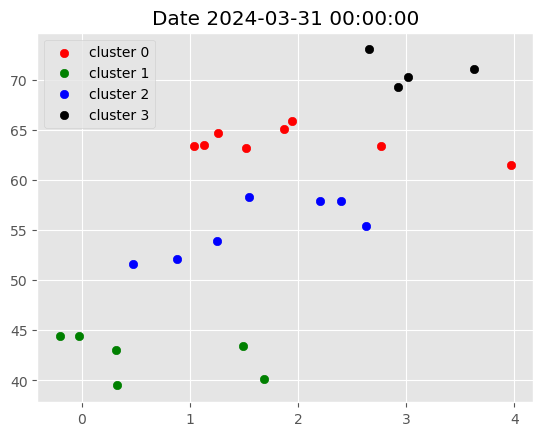

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [33]:
filtered_df = data[data['cluster']==0].copy()  # eveything lies here so use cluster value carefully

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-05-01': ['INFY.NS', 'SUNPHARMA.NS', 'TCS.NS'],
 '2017-06-01': ['BHARTIARTL.NS',
  'HCLTECH.NS',
  'INDUSINDBK.NS',
  'LT.NS',
  'M&M.NS',
  'TATAMOTORS.NS',
  'TATASTEEL.NS',
  'TCS.NS'],
 '2017-07-01': ['BHARTIARTL.NS', 'HDFCBANK.NS', 'HEROMOTOCO.NS', 'MARUTI.NS'],
 '2017-08-01': ['ADANIPORTS.NS',
  'HDFCBANK.NS',
  'INDUSINDBK.NS',
  'MARUTI.NS',
  'RELIANCE.NS',
  'SBIN.NS'],
 '2017-09-01': ['TATAMOTORS.NS'],
 '2017-10-01': ['ICICIBANK.NS', 'ITC.NS', 'M&M.NS', 'SBIN.NS'],
 '2017-11-01': ['LT.NS', 'MARUTI.NS'],
 '2017-12-01': ['MARUTI.NS'],
 '2018-01-01': ['MARUTI.NS'],
 '2018-02-01': ['BHARTIARTL.NS'],
 '2018-03-01': ['AXISBANK.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'ICICIBANK.NS',
  'SBIN.NS',
  'TATAMOTORS.NS'],
 '2018-04-01': ['ADANIPORTS.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'SUNPHARMA.NS',
  'TATAMOTORS.NS',
  'TATASTEEL.NS'],
 '2018-05-01': ['BAJFINANCE.NS',
  'EICHERMOT.NS',
  'INDUSINDBK.NS',
  'ITC.NS',
  'LT.NS'],
 '2018-06-01': ['TATAMOTORS.NS'],
 '2018-07-01':

# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  33 of 33 completed


Adj Close                                           \
            ADANIENT.NS ADANIPORTS.NS ASIANPAINT.NS  AXISBANK.NS   
Date                                                               
2016-05-02    46.476772    223.721710    819.145874   461.133789   
2016-05-03    45.862778    226.170700    825.965942   459.912109   
2016-05-04    42.258896    200.000214    827.481262   451.995239   
2016-05-05    41.698292    190.156281    821.277161   450.626862   
2016-05-06    40.977516    186.842957    842.115845   451.017853   
...                 ...           ...           ...          ...   
2024-03-07  3226.550049   1325.449951   2870.550049  1111.449951   
2024-03-11  3207.350098   1326.949951   2876.850098  1105.099976   
2024-03-12  3122.500000   1301.300049   2876.149902  1097.000000   
2024-03-13  2906.199951   1209.550049   2860.149902  1080.400024   
2024-03-14  3057.899902   1254.500000   2887.949951  1075.800049   

                                                                               \
           BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS     BPCL.NS   DRREDDY.NS   
Date                                                                            
2016-05-02    193.459091    689.413940    309.714722  206.415588  2818.829102   
2016-05-03    194.146866    682.743408    318.846893  203.083801  2769.739746   
2016-05-04    188.729523    679.684082    312.874176  201.625397  2745.358398   
2016-05-05    188.191254    699.358704    306.771606  199.868988  2741.848877   
2016-05-06    186.706116    710.007263    310.839935  199.954147  2682.651123   
...                  ...           ...           ...         ...          ...   
2024-03-07   1582.800049   6421.049805   1199.699951  624.700012  6324.149902   
2024-03-11   1598.800049   6433.750000   1196.599976  626.400024  6387.450195   
2024-03-12   1593.550049   6436.049805   1204.250000  625.450012  6302.149902   
2024-03-13   1573.150024   6456.149902   1168.750000  597.750000  6303.799805   
2024-03-14   1575.699951   6451.700195   1185.750000  601.650024  6265.000000   

                         ...      Volume                                       \
           EICHERMOT.NS  ... RELIANCE.NS   SBIN.NS SUNPHARMA.NS TATAMOTORS.NS   
Date                     ...                                                    
2016-05-02  1895.289062  ...     5310436  14469844      1083227       4178821   
2016-05-03  1907.427002  ...     8785913  16247931      5809209       9620804   
2016-05-04  1886.363647  ...     6773142  17826594      2523074      12069134   
2016-05-05  1879.280273  ...    10832842  17742028      3065087       9601341   
2016-05-06  1929.802490  ...     7374164  18336962      1464262       9953672   
...                 ...  ...         ...       ...          ...           ...   
2024-03-07  3785.250000  ...     4157863  15497868      2440999      16877082   
2024-03-11  3783.899902  ...     5638565  16778340      2994345       7502450   
2024-03-12  3810.750000  ...     4716339  21529705      1294598       8763820   
2024-03-13  3735.550049  ...     6761067  27950252      2881503      16564155   
2024-03-14  3754.699951  ...     3403864   8906699      1242367      13105005   

                                                                           
           TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS ULTRACEMCO.NS WIPRO.NS  
Date                                                                       
2016-05-02     43887322  1116692  1076011   966084        151083  2648204  
2016-05-03     66909161  2153118  1721645   963168        328289  4605201  
2016-05-04     83523154  1364892  1379336  1040577        127389  3498556  
2016-05-05     87494787  1246566  1484568  1448922        281986  2912359  
2016-05-06     56288545   885598   948747  1508866        237698  3435209  
...                 ...      ...      ...      ...           ...      ...  
2024-03-07    124847699  2688905  2073691   838514        585012  4853991  
2024-03-11     54155385  230406

In [23]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-04-30 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [24]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-05-02        -0.013102
2017-05-03        -0.009977
2017-05-04        -0.009569
2017-05-05        -0.029846
2017-05-08         0.001657
...                     ...
2024-03-07        -0.003108
2024-03-11        -0.010176
2024-03-12        -0.006281
2024-03-13        -0.017638
2024-03-14        -0.004384

[1700 rows x 1 columns]

<Axes: xlabel='date'>

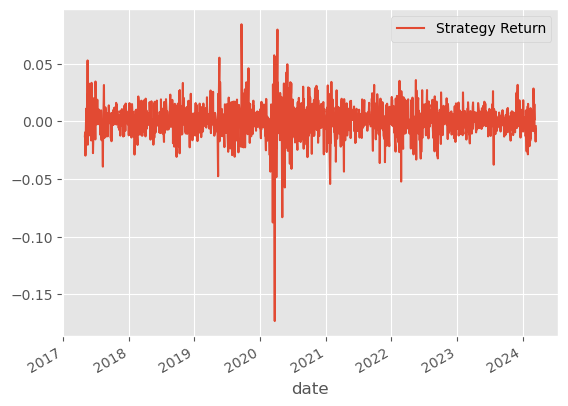

In [25]:
portfolio_df.plot()

In [26]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

BAJFINANCE.NS  HDFCBANK.NS  HINDALCO.NS  HINDUNILVR.NS    ITC.NS  \
0       0.166667     0.166667     0.166667       0.166667  0.166667   

   KOTAKBANK.NS  
0      0.166667

In [27]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-05-02        -0.013102        0.001047
2017-05-03        -0.009977       -0.000199
2017-05-04        -0.009569        0.005136
2017-05-05        -0.029846       -0.008002
2017-05-08         0.001657        0.003092
...                     ...             ...
2024-03-06         0.014780        0.005253
2024-03-07        -0.003108        0.000867
2024-03-11        -0.010176       -0.007179
2024-03-12        -0.006281        0.000137
2024-03-13        -0.017638       -0.015248

[1695 rows x 2 columns]

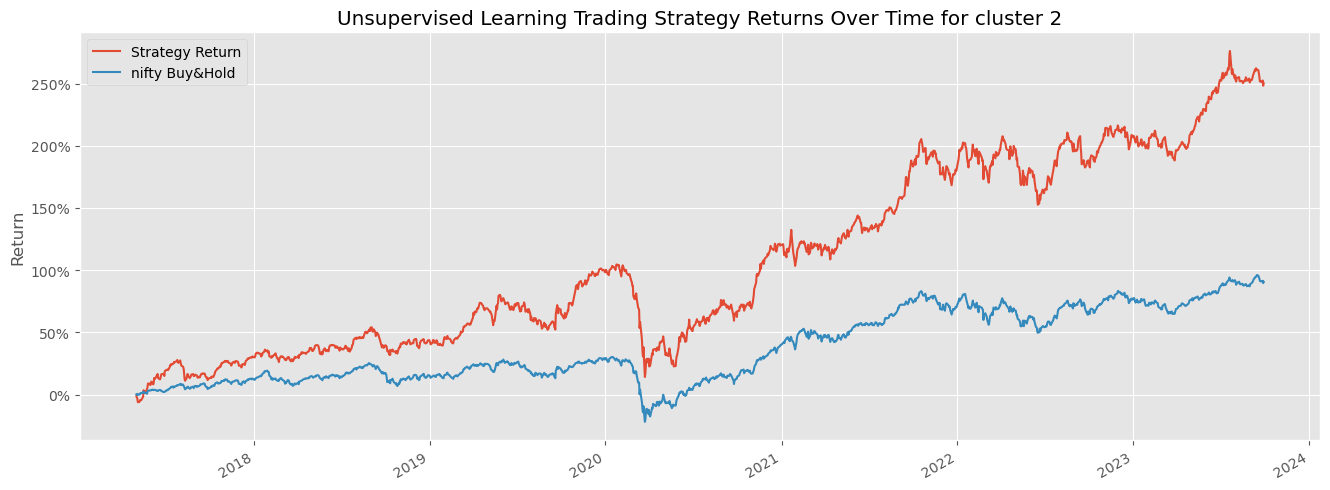

In [28]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster 2')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [29]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 0.9542
NIFTY 50 Sharpe Ratio: 0.7307
